### RF - Cost/Impurity = log loss (cross entropy) + wCE + cost = class weights = IR, 1.5
<br>
<b><font color = 'blue' > Exp: A3 ---- Easy to Hard - Full, High, Low, Only One agreements - Top G% </font></b>
<br> cost = IR = min count /maj count -- provided as class weights

### NOTE: Selected Features only

<b>Note: </b> <br>
Tabular data stored        - data <br>
Image data, not normalized - all_images <br>
All nodule IDs             - all_noduleId <br>
Image data normalized      - all_normalized_image <br>

In [66]:
# Import Libaries
import numpy as np
import pandas as pd
import os
import statistics
from matplotlib import pyplot as plt
import os
from os import path
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
import scipy.stats as stats
import matplotlib.ticker as ticker
from scipy.stats import levene
import math
import time
import psutil
import GPUtil

import warnings

warnings.filterwarnings('ignore')


In [67]:
start_time = time.process_time()
# Read CSV data
data = pd.read_csv("MaxSlices_newMode_Manuf_Int.csv", index_col = 0)

# Print data
data.head(5)

# Define the directory path
directory = './_SubsetsCreated/RF/RF_New_FHLOne_Agr'

# Create the directory if it doesn't exist
os.makedirs(directory, exist_ok=True)



In [68]:
# Malignancy
data.iloc[:, [8]]

,Malignancy
MY_ID,
1,5
2,5
3,5
4,4
5,4
...,...
2683,4
2684,2
2685,2


In [69]:
# remove observations for which text version of the images do not exist
# nodules : 309, 1212, 1281, 1459, 1712, 2507, 2596

# before removal
print(len(data))
print(data.shape)

dfx = data.loc[(data["noduleID"] != 309) & (data["noduleID"] != 1212) & (data["noduleID"] != 1281) & (data["noduleID"] != 1459) & (data["noduleID"] != 1712) & (data["noduleID"] != 2507) & (data["noduleID"] != 2596)]
print(dfx.shape)
data = dfx
print(data.shape)

2687
(2687, 136)
(2680, 136)
(2680, 136)


In [70]:
print(len(data))
print(data.shape)

dmx = data.loc[(data["d_MalignancyDesc"] != 'Indeterminant')]
print(dmx.shape)
data = dmx
print(data.shape)

2680
(2680, 136)
(1488, 136)
(1488, 136)


In [71]:
print(data['Malignancy'].value_counts()[1])
print(data['Malignancy'].value_counts()[2])
print(data['Malignancy'].value_counts()[4])
print(data['Malignancy'].value_counts()[5])

print(data['d_MalignancyDesc'].value_counts()['Benign'])
print(data['d_MalignancyDesc'].value_counts()['Malignant'])
#print(data['d_MalignancyDesc'].value_counts()['Indeterminant'])

335
562
356
235
897
591


## Common Section

In [72]:
# Manufacture types = GE MEDICAL SYSTEMS (1623), SIEMENS (586), TOSHIBA (191), Philips (287) - before removing
# Manufacture types = GE MEDICAL SYSTEMS (1623), SIEMENS (580), TOSHIBA (191), Philips (286) - after removing
Manuf_GE = data[data['Manufacturer']== "GE Medical Systems"]
Manuf_S = data[data['Manufacturer']== "Siemens"]
Manuf_T = data[data['Manufacturer']== "Toshiba"]
Manuf_P = data[data['Manufacturer']== "Philips"]

# Print data counts
print(Manuf_GE.shape)
print(Manuf_S.shape)
print(Manuf_T.shape)
print(Manuf_P.shape)

(934, 136)
(321, 136)
(100, 136)
(133, 136)


## Functions

In [ ]:
def monitor_cpu_utilization():
    cpu_utilization = psutil.cpu_percent()
    print(f"CPU Utilization: {cpu_utilization}%")

def monitor_gpu_utilization():
    gpus = GPUtil.getGPUs()
    for gpu in gpus:
        print(f"GPU {gpu.id}: Utilization {gpu.load * 100}%")

In [73]:
def compute_mu_std(var_passed):

    mean_1 = np.round_(np.mean(var_passed), decimals = 4)
    SD_1 = np.round_(np.std(var_passed), decimals = 4)
    #mean_std = "Mu = " + str(mean_1) + ", Std = " + str(SD_1)
    return mean_1, SD_1

In [74]:
# Global Normalization -- Normalize all images using global values for max = 4095 and min = -2048
def NormImg(orig_array, new_min = 0, new_max = 255, orig_max = 4095, orig_min = -2048, set_to_int = True):
    new_var = orig_array.copy()
    #print(new_var)
    nu = new_var - orig_min
    de = orig_max - orig_min
    mul= new_max - new_min
    new_var = (nu/de) * mul

    if set_to_int:
        return new_var.astype('uint8')
    return new_var

In [75]:
# Local Normalization -- Normalize all images using each image's max and min
def getNormed(this_array, this_min = 0, this_max = 255, set_to_int = True):
    new_var = this_array.copy()
    rat = (this_max - this_min)/(new_var.max() - new_var.min())
    new_var = new_var * rat
    new_var -= new_var.min()
    new_var += this_min

    if set_to_int:
        return new_var.astype('uint8')
    return new_var

In [76]:
def int_byManuf(manuf_array):

    for i in range(0, len(manuf_array)):
        nodule = manuf_array.iloc[i, 9]
        noduleS = str(nodule)
        indexPos = all_noduleId.index(noduleS)
        intensity_manuf = all_images[indexPos]

    return intensity_manuf

In [77]:
# T-TEST - decision

def sigPval(p_value):

    if (p_value > 0.05):
        resultDesc = 'Same'
    else:
        resultDesc = 'Different'

    return resultDesc

In [78]:
# Fisher-TEST - decision

# Null (H0): There is no association between gender and voting. They are independent.
# Alternative (HA): A relationship between gender and voting exists in the population

def sigFisherPval(p_value):

    if (p_value > 0.05):
        resultDesc = 'No Association'
    else:
        resultDesc = 'Association'

    return resultDesc

In [79]:
def tetrachoricCorr(data_new):

    a = data_new[0][0]
    b = data_new[1][0]
    c = data_new[0][1]
    d = data_new[1][1]

    a1 = math.sqrt(a*d/b/c)
    a2 = 1 + a1
    a3 = math.pi / a2
    tCorr = math.cos(a3)
    return tCorr

In [80]:
def computeCorr_binaryToBinary (x, y):

    data_new = pd.crosstab(x, y).round(0)

    # Fisher Test
    # stat1 is the odd's ratio
    stat1, p_value1 = stats.fisher_exact(data_new)
    sigDesc1 = sigFisherPval(p_value1)

    #tetrachoric Correlation
    tCorr = tetrachoricCorr(data_new)

    return tCorr

In [81]:
# CROSS ENTROPY LOSS

# https://towardsdatascience.com/intuition-behind-log-loss-score-4e0c9979680a
def logLoss(act, predProb):

    act_lnProb     = act * np.log(predProb)
    act_lnDiffProb = (1-act) * (np.log(1 - (predProb)))
    log_loss  = -(act_lnProb  + act_lnDiffProb)
    return log_loss

In [82]:
# WEIGHTED CROSS ENTROPY LOSS

def wighted_logLoss(act, predProb, w0, w1):

    wtact_lnProb     = w0 * (act * np.log(predProb))                  # first part
    wtact_lnDiffProb = w1 * ((1-act) * (np.log(1 - (predProb))))      # second part
    wtlog_loss       = -(wtact_lnProb  + wtact_lnDiffProb)
    return wtlog_loss

In [83]:
# computeate 95% confidence interval and mean - for performance indicators

def compute_avg_CI (input_df):

    ci= st.t.interval(alpha=0.95, df=len(input_df)-1,
                  loc=np.mean(input_df),
                  scale=st.sem(input_df)),1
    avg = round(np.mean(input_df),1)
    lcl = round((ci[0][0]),1)
    ucl = round((ci[0][1]),1)
    ciRange = str("(") + str(lcl) + str(", ") + str(ucl) + str(")")
    return avg, ciRange


In [84]:
# Generate confusion matrix and compute Sen, Spe, Acc, Pre, F1S
# pass observed/actual y and predicted y

def confMatrixResults (yTrain, yPred):

    cmat = confusion_matrix(yTrain, yPred)
    TN = (cmat[0][0])
    FN = (cmat[1][0])
    FP = (cmat[0][1])
    TP = (cmat[1][1])

    Sen = (TP/(TP+FN))
    Spe = TN / (TN + FP)
    Acc = (TP + TN) / (TP + TN + FP + FN)
    Pre = TP / (TP + FP)
    F1S = (2 * Pre * Sen)/(Pre + Sen)

    Sen = round((Sen*100),2)
    Spe = round((Spe*100),2)
    Acc = round((Acc*100),2)

    Pre = round((Pre*100),2)
    F1S =  round((F1S*100),2)

    return Sen, Spe, Acc, Pre, F1S, TN, FN, FP, TP

In [85]:
# COUNTS: Print counts for training, reserve, test sets
def getCounts(df_Counts, experimentID):
    nOOD_trainD  = df_Counts.where((df_Counts.Method== experimentID)).dropna()['trainSet_nOOD']
    OOD_trainD   = df_Counts.where((df_Counts.Method== experimentID)).dropna()['trainSet_OOD']
    nOOD_reserveD  = df_Counts.where((df_Counts.Method== experimentID)).dropna()['reserveSet_nOOD']
    nOOD_testD     = df_Counts.where((df_Counts.Method== experimentID)).dropna()['testSet_nOOD']
    OOD_reserveD   = df_Counts.where((df_Counts.Method== experimentID)).dropna()['reserveSet_OOD']
    OOD_testD      = df_Counts.where((df_Counts.Method== experimentID)).dropna()['testSet_OOD']
    nOODRetrainD   = df_Counts.where((df_Counts.Method== experimentID)).dropna()['retrainSet_nOOD']
    OOD_RetrainD   = df_Counts.where((df_Counts.Method== experimentID)).dropna()['retrainSet_OOD']

    nOOD_trainD_Avg, nOOD_trainD_CI   = compute_avg_CI (nOOD_trainD)
    OOD_trainD_Avg, OOD_trainD_CI     = compute_avg_CI (OOD_trainD)
    nOOD_reserveD_Avg, nOOD_reserveD_CI = compute_avg_CI (nOOD_reserveD)
    nOOD_testD_Avg, nOOD_testD_CI       = compute_avg_CI (nOOD_testD)
    OOD_reserveD_Avg, OOD_reserveD_CI   = compute_avg_CI (OOD_reserveD)
    OOD_testD_Avg, OOD_testD_CI        = compute_avg_CI (OOD_testD)
    nOODRetrainD_Avg, nOODRetrainDl_CI = compute_avg_CI (nOODRetrainD)
    OOD_RetrainD_Avg, OOD_RetrainD_CI  = compute_avg_CI (OOD_RetrainD)

    print('COUNTS: ', str(experimentID))
    print('Train   - ID   =%f' % (nOOD_trainD_Avg))
    print('Train   - OoD  =%f' % (OOD_trainD_Avg))
    print('reserve - ID   =%f' % (nOOD_reserveD_Avg))
    print('reserve - OoD  =%f' % (OOD_reserveD_Avg))
    print('Test    - ID   =%f' % (nOOD_testD_Avg))
    print('Test    - OoD  =%f' % (OOD_testD_Avg))
    print('Retrain - ID   =%f' % (nOODRetrainD_Avg))
    print('Retrain - OoD  =%f' % (OOD_RetrainD_Avg))

In [86]:
# COMPUTE PERFORMANCES: create subsets to compute avg and CI

def getPerformance(df_CM, experimentID):

    Sen_trainD = df_CM.where((df_CM.Method== experimentID)).dropna()['Sen_train']
    Spe_trainD = df_CM.where((df_CM.Method== experimentID)).dropna()['Spe_train']
    Acc_trainD = df_CM.where((df_CM.Method== experimentID)).dropna()['Acc_train']
    Pre_trainD = df_CM.where((df_CM.Method== experimentID)).dropna()['Pre_train']
    F1_trainD  = df_CM.where((df_CM.Method== experimentID)).dropna()['F1_train']

    Sen_retrainD = df_CM.where((df_CM.Method== experimentID)).dropna()['Sen_retrain']
    Spe_retrainD = df_CM.where((df_CM.Method== experimentID)).dropna()['Spe_retrain']
    Acc_retrainD = df_CM.where((df_CM.Method== experimentID)).dropna()['Acc_retrain']
    Pre_retrainD = df_CM.where((df_CM.Method== experimentID)).dropna()['Pre_retrain']
    F1_retrainD  = df_CM.where((df_CM.Method== experimentID)).dropna()['F1_retrain']

    Sen_testD = df_CM.where((df_CM.Method== experimentID)).dropna()['Sen_test']
    Spe_testD = df_CM.where((df_CM.Method== experimentID)).dropna()['Spe_test']
    Acc_testD = df_CM.where((df_CM.Method== experimentID)).dropna()['Acc_test']
    Pre_testD = df_CM.where((df_CM.Method== experimentID)).dropna()['Pre_test']
    F1_testD  = df_CM.where((df_CM.Method== experimentID)).dropna()['F1_test']


    TP_trainD = df_CM.where((df_CM.Method== experimentID)).dropna()['train_TP']
    TN_trainD = df_CM.where((df_CM.Method== experimentID)).dropna()['train_TN']
    FP_trainD = df_CM.where((df_CM.Method== experimentID)).dropna()['train_FP']
    FN_trainD = df_CM.where((df_CM.Method== experimentID)).dropna()['train_FN']
    TP_retrainD = df_CM.where((df_CM.Method== experimentID)).dropna()['retrain_TP']
    TN_retrainD = df_CM.where((df_CM.Method== experimentID)).dropna()['retrain_TN']
    FP_retrainD = df_CM.where((df_CM.Method== experimentID)).dropna()['retrain_FP']
    FN_retrainD = df_CM.where((df_CM.Method== experimentID)).dropna()['retrain_FN']
    TP_testD = df_CM.where((df_CM.Method== experimentID)).dropna()['test_TP']
    TN_testD = df_CM.where((df_CM.Method== experimentID)).dropna()['test_TN']
    FP_testD = df_CM.where((df_CM.Method== experimentID)).dropna()['test_FP']
    FN_testD = df_CM.where((df_CM.Method== experimentID)).dropna()['test_FN']



    # Step-3: compute avg and CI
    Sen_Train_Avg, Sen_Train_CI = compute_avg_CI (Sen_trainD)
    Spe_Train_Avg, Spe_Train_CI = compute_avg_CI (Spe_trainD)
    Acc_Train_Avg, Acc_Train_CI = compute_avg_CI (Acc_trainD)
    Pre_Train_Avg, Pre_Train_CI = compute_avg_CI (Pre_trainD)
    F1_Train_Avg, F1_Train_CI   = compute_avg_CI (F1_trainD)

    Sen_retrain_Avg, Sen_retrain_CI = compute_avg_CI (Sen_retrainD)
    Spe_retrain_Avg, Spe_retrain_CI = compute_avg_CI (Spe_retrainD)
    Acc_retrain_Avg, Acc_retrain_CI = compute_avg_CI (Acc_retrainD)
    Pre_retrain_Avg, Pre_retrain_CI = compute_avg_CI (Pre_retrainD)
    F1_retrain_Avg, F1_retrain_CI   = compute_avg_CI (F1_retrainD)

    Sen_test_Avg, Sen_test_CI = compute_avg_CI (Sen_testD)
    Spe_test_Avg, Spe_test_CI = compute_avg_CI (Spe_testD)
    Acc_test_Avg, Acc_test_CI = compute_avg_CI (Acc_testD)
    Pre_test_Avg, Pre_test_CI = compute_avg_CI (Pre_testD)
    F1_test_Avg, F1_test_CI   = compute_avg_CI (F1_testD)


    train_TP,  train_TP_ci = compute_avg_CI (TP_trainD)
    train_TN,  train_TN_ci = compute_avg_CI (TN_trainD)
    train_FP,  train_FP_ci = compute_avg_CI (FP_trainD)
    train_FN,  train_FN_ci = compute_avg_CI (FN_trainD)
    retrain_TP,  retrain_TP_ci = compute_avg_CI (TP_retrainD)
    retrain_TN,  retrain_TN_ci = compute_avg_CI (TN_retrainD)
    retrain_FP,  retrain_FP_ci = compute_avg_CI (FP_retrainD)
    retrain_FN,  retrain_FN_ci = compute_avg_CI (FN_retrainD)
    test_TP,  test_TP_ci = compute_avg_CI (TP_testD)
    test_TN,  test_TN_ci = compute_avg_CI (TN_testD)
    test_FP,  test_FP_ci = compute_avg_CI (FP_testD)
    test_FN,  test_FN_ci = compute_avg_CI (FN_testD)




    # Step-4: print avg and CI
    print('-------------------------------')
    print('PERFORMANCE:', str(experimentID))
    print('Training')
    print('Sen = ', str(Sen_Train_Avg), str(Sen_Train_CI))
    print('Spe = ', str(Spe_Train_Avg), str(Spe_Train_CI))
    print('Acc = ', str(Acc_Train_Avg), str(Acc_Train_CI))
    # print('P = ', str(Pre_Train_Avg), str(Pre_Train_CI))
    # print('F1 = ', str(F1_Train_Avg), str(F1_Train_CI))
    print('--------------------------')

    print('Retraining')
    print('Sen = ', str(Sen_retrain_Avg), str(Sen_retrain_CI))
    print('Spe = ', str(Spe_retrain_Avg), str(Spe_retrain_CI))
    print('Acc = ', str(Acc_retrain_Avg), str(Acc_retrain_CI))
    # print('P = ', str(Pre_retrain_Avg), str(Pre_retrain_CI))
    # print('F1 = ', str(F1_retrain_Avg), str(F1_retrain_CI))
    print('--------------------------')

    print('Test')
    print('Sen = ', str(Sen_test_Avg), str(Sen_test_CI))
    print('Spe = ', str(Spe_test_Avg), str(Spe_test_CI))
    print('Acc = ', str(Acc_test_Avg), str(Acc_test_CI))
    # print('P = ', str(Pre_test_Avg), str(Pre_test_CI))
    # print('F1 = ', str(F1_test_Avg), str(F1_test_CI))


    print('--------------------------')
    print('Classification Results')
    print('Train : TP , TN, FP, FN = ', str(train_TP), str(train_TN), str(train_FP), str(train_FN))
    print('Retrain : TP , TN, FP, FN = ', str(retrain_TP), str(retrain_TN), str(retrain_FP), str(retrain_FN))
    print('Test : TP , TN, FP, FN = ', str(test_TP), str(test_TN), str(test_FP), str(test_FN))

In [87]:
# OoD Score Range for ID and OoD Samples
def getOoDScoreRange(df_OodRange, experimentID):
    Train_ID    = df_OodRange.loc[(df_OodRange["Method"] == experimentID) & (df_OodRange["TType"] == "Train") & (df_OodRange["SampleType"] == "ID")]
    Retrain_ID  = df_OodRange.loc[(df_OodRange["Method"] == experimentID) & (df_OodRange["TType"] == "Retrain") & (df_OodRange["SampleType"] == "ID")]
    Retrain_OOD = df_OodRange.loc[(df_OodRange["Method"] == experimentID) & (df_OodRange["TType"] == "Retrain") & (df_OodRange["SampleType"] == "OOD")]
    Test_ID     = df_OodRange.loc[(df_OodRange["Method"] == experimentID) & (df_OodRange["TType"] == "Test") & (df_OodRange["SampleType"] == "ID")]
    Test_OOD    = df_OodRange.loc[(df_OodRange["Method"] == experimentID) & (df_OodRange["TType"] == "Test") & (df_OodRange["SampleType"] == "OOD")]


    print("------------------------------")
    print("OoD Score Range")
    print(experimentID)
    print("Train ID   : ", Train_ID['MinOodScore'].min(), Train_ID['MaxOodScore'].max())
    print("Retrain ID : ", Retrain_ID['MinOodScore'].min(), Retrain_ID['MaxOodScore'].max())
    print("Retrain OOD: ", Retrain_OOD['MinOodScore'].min(), Retrain_OOD['MaxOodScore'].max())
    print("Test ID    : ", Test_ID['MinOodScore'].min(), Test_ID['MaxOodScore'].max())
    print("Test OOD   : ", Test_OOD['MinOodScore'].min(), Test_OOD['MaxOodScore'].max())



In [88]:
def getKLDRange(experimentID, C):

    expKLD_sumByFeatureTT = []
    expKLD_sumByFeatureRT = []

    maxLength = (df_KLD["Iter_ID"]).max()

    for j in range (1, maxLength+1):

        expKLD_sumTT = df_KLD.loc[((df_KLD["Iter_ID"] == j) & (df_KLD["Method"] == experimentID) & (df_KLD["Types"] == C)), 'KLD_t_t'].sum()
        expKLD_sumByFeatureTT.append(expKLD_sumTT)

        expKLD_sumRT = df_KLD.loc[((df_KLD["Iter_ID"] == j) & (df_KLD["Method"] == experimentID) & (df_KLD["Types"] == C)), 'KLD_rt_t'].sum()
        expKLD_sumByFeatureRT.append(expKLD_sumRT)


    expKLD_avgTT,  expKLD_ciTT = compute_avg_CI (expKLD_sumByFeatureTT)
    expKLD_avgRT,  expKLD_ciRT = compute_avg_CI (expKLD_sumByFeatureRT)
    print('---------------------------')
    print('KLD - ', C , '-----------------------')
    print("Train-Test", str(expKLD_avgTT), str(expKLD_ciTT))
    print("Retrain-Test", str(expKLD_avgRT), str(expKLD_ciRT))

In [89]:
# KLD Functions

def KL_Continious(data_1, data_2):
    # Epsilon is used here to avoid conditional code for checking that neither P nor Q is equal to 0. """
    epsilon = 0.00001

    # binn the continious value to be able to compute probabilities
    # https://www.geeksforgeeks.org/how-to-calculate-and-plot-a-cumulative-distribution-function-with-matplotlib-in-python/
    count1, bins_count1 = np.histogram(data_1, bins=50)
    count2, bins_count2 = np.histogram(data_2, bins=50)

    # compute probability - number of itemts in the bin/total
    P = count1/np.sum(count1)
    Q = count2/np.sum(count2)

    # You may want to instead make copies to avoid changing the np arrays.
    P = P+epsilon
    Q = Q+epsilon

    divergence = round(np.sum(P*np.log(P/Q)),4)
    return divergence


# for discrete and categorical
def KL_binary(data_1, data_2):
    # Epsilon is used here to avoid conditional code for checking that neither P nor Q is equal to 0. """
    epsilon = 0.00001

    # bin the binary varibale to 2 bins value to be able to compute probabilities
    # https://www.geeksforgeeks.org/how-to-calculate-and-plot-a-cumulative-distribution-function-with-matplotlib-in-python/
    count1, bins_count1 = np.histogram(data_1, bins=2)
    count2, bins_count2 = np.histogram(data_2, bins=2)

    # compute probability - number of itemts in the bin/total
    P = count1/np.sum(count1)
    Q = count2/np.sum(count2)

    # You may want to instead make copies to avoid changing the np arrays.
    P = P+epsilon
    Q = Q+epsilon

    divergence = round(np.sum(P*np.log(P/Q)),4)
    return divergence


# to create sns.count plots for binary variables
def createDF(f1, f2, f3, f4, ds1, ds2, ds3, ds4, var):

    df1 = pd.DataFrame(columns=['MainType', 'Type', var])
    df2 = pd.DataFrame(columns=['MainType', 'Type', var])
    df3 = pd.DataFrame(columns=['MainType', 'Type', var])
    df4 = pd.DataFrame(columns=['MainType', 'Type', var])

    for i in range (0, len(ds1)):
        df1['MainType'] = 'Train and Test'
        df1['Type'] = 'Train'
        df1[var] = f1

    for i in range (0, len(ds2)):
        df2['MainType'] = 'Train and Test'
        df2['Type'] = 'Test'
        df2[var] = f2

    frames = [df1, df2]
    df1 = pd.concat(frames)

    for i in range (0, len(ds3)):
        df3['MainType'] = 'Retrain and Test'
        df3['Type'] = 'Retrain'
        df3[var] = f3

    for i in range (0, len(ds4)):
        df4['MainType'] = 'Retrain and Test'
        df4['Type'] = 'Test'
        df4[var] = f4

    frames = [df3, df4]
    df2 = pd.concat(frames)

    return df1, df2


# KLD - computation for cumulative graphs
# continious
def create_KLD_datasetC(T, T1, RT, T2, feature, numIter, experimentID, C ):

    global df_KLD

    result_KL12 = KL_Continious(T, T1)
    result_KL34 = KL_Continious(RT, T2)
    diff = round(result_KL12 - result_KL34,4)

    df_KLD = df_KLD.append({'Iter_ID': numIter , 'Method': experimentID,
                            'Features': feature , 'KLD_t_t': result_KL12 , 'KLD_rt_t': result_KL34,
                            'Types': C}, ignore_index=True)

    print(experimentID, C, result_KL34)

    return result_KL12, result_KL34


# binary
def create_KLD_datasetB(T, T1, RT, T2, feature, numIter, experimentID, C ):

    global df_KLD

    result_KL12 = KL_binary(T, T1)
    result_KL34 = KL_binary(RT, T2)
    diff = round(result_KL12 - result_KL34,4)

    df_KLD = df_KLD.append({'Iter_ID': numIter , 'Method': experimentID,
                            'Features': feature , 'KLD_t_t': result_KL12 , 'KLD_rt_t': result_KL34,
                            'Types': C}, ignore_index=True)


    print(experimentID, C, result_KL34)

    #return result_KL12, result_KL34



def KLD_cummValues(numIter, experimentID, gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_retrain_dataF, gf1Smm_test_dataF, C):
    # KLD Cumulative graph


    create_KLD_datasetC(gf1Smm_train_dataF.ConvexArea, gf1Smm_reserve_dataF.ConvexArea,
       gf1Smm_retrain_dataF.ConvexArea, gf1Smm_test_dataF.ConvexArea, 'ConvexArea', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.Perimeter, gf1Smm_reserve_dataF.Perimeter,
       gf1Smm_retrain_dataF.Perimeter, gf1Smm_test_dataF.Perimeter, 'Perimeter', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.EquivDiameter, gf1Smm_reserve_dataF.EquivDiameter,
       gf1Smm_retrain_dataF.EquivDiameter, gf1Smm_test_dataF.EquivDiameter, 'EquivDiameter', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.MajorAxisLength, gf1Smm_reserve_dataF.MajorAxisLength,
       gf1Smm_retrain_dataF.MajorAxisLength, gf1Smm_test_dataF.MajorAxisLength, 'MajorAxisLength', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.MinorAxisLength, gf1Smm_reserve_dataF.MinorAxisLength,
       gf1Smm_retrain_dataF.MinorAxisLength, gf1Smm_test_dataF.MinorAxisLength, 'MinorAxisLength', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.Elongation, gf1Smm_reserve_dataF.Elongation,
       gf1Smm_retrain_dataF.Elongation, gf1Smm_test_dataF.Elongation, 'Elongation', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.Compactness, gf1Smm_reserve_dataF.Compactness,
       gf1Smm_retrain_dataF.Compactness, gf1Smm_test_dataF.Compactness, 'Compactness', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.Eccentricity, gf1Smm_reserve_dataF.Eccentricity,
       gf1Smm_retrain_dataF.Eccentricity, gf1Smm_test_dataF.Eccentricity, 'Eccentricity', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.Solidity, gf1Smm_reserve_dataF.Solidity,
       gf1Smm_retrain_dataF.Solidity, gf1Smm_test_dataF.Solidity, 'Solidity', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.Extent, gf1Smm_reserve_dataF.Extent,
       gf1Smm_retrain_dataF.Extent, gf1Smm_test_dataF.Extent, 'Extent', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.Circularity, gf1Smm_reserve_dataF.Circularity,
       gf1Smm_retrain_dataF.Circularity, gf1Smm_test_dataF.Circularity, 'Circularity', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.x_3rdordermoment, gf1Smm_reserve_dataF.x_3rdordermoment,
       gf1Smm_retrain_dataF.x_3rdordermoment, gf1Smm_test_dataF.x_3rdordermoment, 'x_3rdordermoment', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.Clustertendency, gf1Smm_reserve_dataF.Clustertendency,
       gf1Smm_retrain_dataF.Clustertendency, gf1Smm_test_dataF.Clustertendency, 'Clustertendency', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.MaxProbability, gf1Smm_reserve_dataF.MaxProbability,
       gf1Smm_retrain_dataF.MaxProbability, gf1Smm_test_dataF.MaxProbability, 'MaxProbability', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.Entropy, gf1Smm_reserve_dataF.Entropy,
       gf1Smm_retrain_dataF.Entropy, gf1Smm_test_dataF.Entropy, 'Entropy', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.ConvexPerimeter, gf1Smm_reserve_dataF.ConvexPerimeter,
       gf1Smm_retrain_dataF.ConvexPerimeter, gf1Smm_test_dataF.ConvexPerimeter, 'ConvexPerimeter', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.Energy, gf1Smm_reserve_dataF.Energy,
       gf1Smm_retrain_dataF.Energy, gf1Smm_test_dataF.Energy, 'Energy', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.RadialDistanceSD, gf1Smm_reserve_dataF.RadialDistanceSD,
       gf1Smm_retrain_dataF.RadialDistanceSD, gf1Smm_test_dataF.RadialDistanceSD, 'RadialDistanceSD', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.gabormean_2_0, gf1Smm_reserve_dataF.gabormean_2_0,
       gf1Smm_retrain_dataF.gabormean_2_0, gf1Smm_test_dataF.gabormean_2_0, 'gabormean_2_0', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.gabormean_2_1, gf1Smm_reserve_dataF.gabormean_2_1,
       gf1Smm_retrain_dataF.gabormean_2_1, gf1Smm_test_dataF.gabormean_2_1, 'gabormean_2_1', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.gabormean_0_0, gf1Smm_reserve_dataF.gabormean_0_0,
       gf1Smm_retrain_dataF.gabormean_0_0, gf1Smm_test_dataF.gabormean_0_0, 'gabormean_0_0', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.gabormean_3_2, gf1Smm_reserve_dataF.gabormean_3_2,
       gf1Smm_retrain_dataF.gabormean_3_2, gf1Smm_test_dataF.gabormean_3_2, 'gabormean_3_2', numIter, experimentID, C)

    create_KLD_datasetC(gf1Smm_train_dataF.gabormean_3_0, gf1Smm_reserve_dataF.gabormean_3_0,
       gf1Smm_retrain_dataF.gabormean_3_0, gf1Smm_test_dataF.gabormean_3_0, 'gabormean_3_0', numIter, experimentID, C)

    create_KLD_datasetB(gf1Smm_train_dataF.dSpic2_5, gf1Smm_reserve_dataF.dSpic2_5,
       gf1Smm_retrain_dataF.dSpic2_5, gf1Smm_test_dataF.dSpic2_5, 'dSpic2_5', numIter, experimentID, C)

    create_KLD_datasetB(gf1Smm_train_dataF.dLob2_5, gf1Smm_reserve_dataF.dLob2_5,
       gf1Smm_retrain_dataF.dLob2_5, gf1Smm_test_dataF.dLob2_5, 'dLob2_5', numIter, experimentID, C)

    create_KLD_datasetB(gf1Smm_train_dataF.dCal3, gf1Smm_reserve_dataF.dCal3,
       gf1Smm_retrain_dataF.dCal3, gf1Smm_test_dataF.dCal3, 'dCal3', numIter, experimentID, C)

    create_KLD_datasetB(gf1Smm_train_dataF.dSubtl1_3, gf1Smm_reserve_dataF.dSubtl1_3,
       gf1Smm_retrain_dataF.dSubtl1_3, gf1Smm_test_dataF.dSubtl1_3, 'dSubtl1_3', numIter, experimentID, C)

    create_KLD_datasetB(gf1Smm_train_dataF.dIstru1, gf1Smm_reserve_dataF.dIstru1,
       gf1Smm_retrain_dataF.dIstru1, gf1Smm_test_dataF.dIstru1, 'dIstru1', numIter, experimentID, C)

    create_KLD_datasetB(gf1Smm_train_dataF.dManuf_GE, gf1Smm_reserve_dataF.dManuf_GE,
       gf1Smm_retrain_dataF.dManuf_GE, gf1Smm_test_dataF.dManuf_GE, 'dManuf_GE', numIter, experimentID, C)

    create_KLD_datasetB(gf1Smm_train_dataF.dManuf_S, gf1Smm_reserve_dataF.dManuf_S,
       gf1Smm_retrain_dataF.dManuf_S, gf1Smm_test_dataF.dManuf_S, 'dManuf_S', numIter, experimentID, C)

    create_KLD_datasetB(gf1Smm_train_dataF.dManuf_P, gf1Smm_reserve_dataF.dManuf_P,
       gf1Smm_retrain_dataF.dManuf_P, gf1Smm_test_dataF.dManuf_P, 'dManuf_P', numIter, experimentID, C)


    #return (kl_divergenceALL_T_T1, kl_divergenceALL_RT_T2, kl_featuresALL_T_T1, kl_featuresALL_RT_T2)




def avgKLDbyFeature(experimentID_orig, experimentID, C):

    feature = ['ConvexArea', 'Perimeter', 'EquivDiameter', 'MajorAxisLength', 'MinorAxisLength', 'Elongation',
    'Compactness', 'Eccentricity', 'Solidity', 'Extent', 'Circularity', 'x_3rdordermoment', 'Clustertendency',
    'MaxProbability', 'Entropy', 'ConvexPerimeter', 'Energy', 'RadialDistanceSD', 'gabormean_2_0', 'gabormean_2_1',
    'gabormean_0_0', 'gabormean_3_2', 'gabormean_3_0', 'dSpic2_5', 'dLob2_5', 'dCal3', 'dSubtl1_3', 'dIstru1',
    'dManuf_GE', 'dManuf_S', 'dManuf_P']


    for i in range (len(feature)):

        KLD_tt = df_KLD.where((df_KLD.Method== experimentID_orig) & (df_KLD.Features == feature[i]) & (df_KLD.Types == C)).dropna()['KLD_t_t']
        KLD_rtt  = df_KLD.where((df_KLD.Method== experimentID) & (df_KLD.Features == feature[i]) & (df_KLD.Types == C)).dropna()['KLD_rt_t']

        avg_tt = round(np.mean(KLD_tt),4)
        avg2_rtt = round(np.mean(KLD_rtt),4)

        kl_divergenceALL_T_T1.append(avg_tt)
        kl_divergenceALL_RT_T2.append(avg2_rtt)
        kl_featuresALL_T_T1.append(feature[i])
        kl_featuresALL_RT_T2.append(feature[i])

    return (kl_divergenceALL_T_T1, kl_divergenceALL_RT_T2, kl_featuresALL_T_T1, kl_featuresALL_RT_T2)



def KLD_cummulativeGraph(kl_divergenceALL_T_T1, kl_divergenceALL_RT_T2, kl_featuresALL_T_T1, kl_featuresALL_RT_T2):

    tot_kl_divergence_T_T1 = round(np.sum(kl_divergenceALL_T_T1),1)
    tot_kl_divergence_RT_T2 = round(np.sum(kl_divergenceALL_RT_T2),1)
    klTitle = 'KL Divergence -  Train/Test= ' + str(tot_kl_divergence_T_T1) + ' vs. Retrain/Test= ' + str(tot_kl_divergence_RT_T2)


    plt.figure(figsize=(16, 5))
    plt.scatter(kl_featuresALL_T_T1, kl_divergenceALL_T_T1, s=35, c='red', label ='Train/Test')
    plt.scatter(kl_featuresALL_RT_T2, kl_divergenceALL_RT_T2, s=35, c='blue', label ='Retrain/Test')
    plt.xlabel("Features", fontsize = 13, fontweight='bold')
    plt.ylabel("KL Divergence", fontsize = 13, fontweight='bold' )
    plt.xticks(kl_featuresALL_T_T1,rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.title(klTitle, fontsize = 16, fontweight='bold')
    plt.ylim(-1, 10)
    plt.legend(fontsize="14")
    plt.grid()
    plt.show()


In [90]:
def vizHist(x1, x2, l1, l2):
    fig, axes = plt.subplots(1, 2, figsize=(12,2.5), sharey=True, sharex=True, dpi=100)
    sns.distplot(x1, bins=100, color="blue", ax=axes[0],  axlabel=l1)
    sns.distplot(x2, bins=100, color="red", ax=axes[1],  axlabel=l2)
    plt.xlim(0, 5)
    plt.ylim(0, 5)

def vizHist2(x1, x2, l1, l2):
    fig, axes = plt.subplots(1, 2, figsize=(12,2.5), sharey=True, sharex=True, dpi=100)
    sns.distplot(x1, bins=100, color="blue", ax=axes[0],  axlabel=l1, kde = False)
    sns.distplot(x2, bins=100, color="red", ax=axes[1],  axlabel=l2, kde = False)
    plt.xlim(0, 5)
    plt.ylim(0, 180)

In [91]:
# Get terminal node (leaf) count

def getLeafCount(rf_classifier, outfile):
    estimator = rf_classifier.estimators_[3]
    y_label = data_io['d_Malignancy'].astype(str)
    y_labelF = y_label.values.tolist()

    export_graphviz(estimator, out_file= outfile,
                    feature_names = cols,
                    class_names = y_labelF,
                    rounded = True, proportion = False,
                    precision = 2, filled = True)

    # Convert to png using system command (requires Graphviz)
    #dot_path = 'C:/Users/mgulasin/Anaconda3/Lib/site-packages/graphviz/dot.py'
    check_call(['dot', '-Tpng', 'tree0.dot', '-o', 'tree0.png', '-Gdpi=600'])

### Create Dummy Variables

In [92]:
# Calcification (has balnk obs) = 1Popcorn, 2Laminated, 3Solid, 4Non-central, 5Central, 6Absent (set as base) | null gets zero
# new mode field for calcification did not include 1,2
data["dCal1"] = 0
data["dCal2"] = 0
data["dCal3"] = 0
data["dCal4"] = 0
data["dCal5"] = 0
data.loc[data["Calcification"] == 1, "dCal1"] = 1
data.loc[data["Calcification"] == 2, "dCal2"] = 1
data.loc[data["Calcification"] == 3, "dCal3"] = 1
data.loc[data["Calcification"] == 4, "dCal4"] = 1
data.loc[data["Calcification"] == 5, "dCal5"] = 1

# Internal (has balnk obs) = 1Soft tissue, 2Fluid, 3Fat, 4Air (set as base) | null also gets zero
data["dIstru1"] = 0
data["dIstru2"] = 0
data["dIstru3"] = 0
data.loc[data["InternalStructure"] == 1, "dIstru1"] = 1
data.loc[data["InternalStructure"] == 2, "dIstru2"] = 1
data.loc[data["InternalStructure"] == 3, "dIstru3"] = 1

# Lobulation = 1None (set as base), 2,3,4, 5Marked --> 1None (set as base), 2-5 (lobulation)
# Using Amal's convension --> from Spiculation field for lobulation --> 1-noLob, 2-5 lobulated
data["dLob2_5"] = 0
data.loc[data["Lobulation"] == 2, "dLob2_5"] = 1
data.loc[data["Lobulation"] == 3, "dLob2_5"] = 1
data.loc[data["Lobulation"] == 4, "dLob2_5"] = 1
data.loc[data["Lobulation"] == 5, "dLob2_5"] = 1

# Spiculation = 1None (set as base), 2,3,4, 5Marked --> 1None (set as base), 2-5 (spiculated)
# Using Amal's convension --> for Spiculation field --> 1-noSpic, 2-5 spiculated
data["dSpic2_5"] = 0
data.loc[data["Spiculation"] == 2, "dSpic2_5"] = 1
data.loc[data["Spiculation"] == 3, "dSpic2_5"] = 1
data.loc[data["Spiculation"] == 4, "dSpic2_5"] = 1
data.loc[data["Spiculation"] == 5, "dSpic2_5"] = 1

# Margin = 1Poorly defined (set as base), 2,3,4, 5Sharp --> 1Poorly defined (set as base), 2-5 (sparp)
data["dMargin2_5"] = 0
data.loc[data["Margin"] == 2, "dMargin2_5"] = 1
data.loc[data["Margin"] == 3, "dMargin2_5"] = 1
data.loc[data["Margin"] == 4, "dMargin2_5"] = 1
data.loc[data["Margin"] == 5, "dMargin2_5"] = 1

#Sphericity = 1Linear, 3Ovoid,5Round --> 1Linear, 2-4Oviod, 5round (set as base)
data["dSpher1"] = 0
data["dSpher2_4"] = 0
data.loc[data["Sphericity"] == 1, "dSpher1"] = 1
data.loc[data["Sphericity"] == 2, "dSpher2_4"] = 1
data.loc[data["Sphericity"] == 3, "dSpher2_4"] = 1
data.loc[data["Sphericity"] == 4, "dSpher2_4"] = 1

# Subtlety = 1Extremely subtle, 2Moderately subtle, 3Fairly subtle, 4Moderately Obvious, 5Obvious (set as base)
#                --> 1-3Subtle, 4-5Obvious(base)
data["dSubtl1_3"] = 0
data.loc[data["Subtlety"] == 1, "dSubtl1_3"] = 1
data.loc[data["Subtlety"] == 2, "dSubtl1_3"] = 1
data.loc[data["Subtlety"] == 3, "dSubtl1_3"] = 1

# Texture= 1Non-solid, 3Part solid (mixed), 5Solid --> 1-4Notsolid(set as base), 5Solid
data["dTexture5"] = 0
data.loc[data["Texture"] == 5, "dTexture5"] = 1

# Manufacturer Name:  GE Medical Systems, Siemens, Toshiba, Philips --> GE, Siemens, Philips, Toshiba (coded as 0)
data["dManuf_GE"] = 0
data["dManuf_S"] = 0
data["dManuf_P"] = 0
data.loc[data["Manufacturer"] == "GE Medical Systems", "dManuf_GE"] = 1
data.loc[data["Manufacturer"] == "Siemens", "dManuf_S"] = 1
data.loc[data["Manufacturer"] == "Philips", "dManuf_P"] = 1


data - latest working dataset w/out outlier removal
data_io - latest dataset without outliers (extreem outliers >= |10|)
            --> NoduleID = 67, 426

In [93]:
# before removal
print(len(data))
print(data.shape)

# remove extreme outliers
data_io = data.loc[(data["noduleID"] != 67) & (data["noduleID"] != 426)]

print(data_io.shape)
# Now you can save the file
data_io.to_csv('./_SubsetsCreated/RF/RF_New_FHLOne_Agr/OOD_BaselineC_Start_logloss.csv')

1488
(1488, 154)
(1486, 154)


In [94]:
# Counts - before outlier removal
print(data['d_Malignancy'].value_counts()[1]) # Malignant
print(data['d_Malignancy'].value_counts()[0]) # Benign
print('--------------')

# Counts - after outlier removal
print(data_io['d_Malignancy'].value_counts()[1]) # Malignant
print(data_io['d_Malignancy'].value_counts()[0]) # Benign

591
897
--------------
591
895


#### Select based on Agreements

In [95]:
data_io.shape

(1486, 154)

In [96]:
data_io["Agreement_Desc"].unique()

array(['High', 'Only One', 'Low', 'No Rating', 'Full'], dtype=object)

In [97]:
# ALL Agreements - 'Full', 'High', 'Low', 'Only One'
data_io = data_io.loc[(data_io["Agreement_Desc"] == 'Full') | (data_io["Agreement_Desc"] ==  'High') | (data_io["Agreement_Desc"] == 'Low') | (data_io["Agreement_Desc"] ==  'Only One')]
data_io.shape

(1403, 154)

# Correlation

### (1) Point-biserial Correlation - Binary vs Continious features

In [98]:
stats.pointbiserialr(data_io.ConvexArea, data_io.d_Malignancy)

SignificanceResult(statistic=0.6019039299201717, pvalue=4.8745590832140145e-139)

In [99]:
stats.pointbiserialr(data_io.Perimeter, data_io.d_Malignancy)

SignificanceResult(statistic=0.6473701215313297, pvalue=1.889394379121407e-167)

In [100]:
stats.pointbiserialr(data_io.EquivDiameter, data_io.d_Malignancy)

SignificanceResult(statistic=0.6948933617151853, pvalue=7.227970072253842e-203)

In [101]:
stats.pointbiserialr(data_io.MajorAxisLength, data_io.d_Malignancy)

SignificanceResult(statistic=0.6769310445415507, pvalue=1.0763206803677157e-188)

In [102]:
stats.pointbiserialr(data_io.MinorAxisLength, data_io.d_Malignancy)

SignificanceResult(statistic=0.6800043893745313, pvalue=4.7764601290519865e-191)

In [103]:
stats.pointbiserialr(data_io.Elongation, data_io.d_Malignancy)

SignificanceResult(statistic=0.13524328276437214, pvalue=3.6836082490334806e-07)

In [104]:
stats.pointbiserialr(data_io.Compactness, data_io.d_Malignancy)

SignificanceResult(statistic=0.33330368792200427, pvalue=9.501290089749664e-38)

In [105]:
stats.pointbiserialr(data_io.Eccentricity, data_io.d_Malignancy)

SignificanceResult(statistic=0.11795107853652119, pvalue=9.441507163620358e-06)

In [106]:
stats.pointbiserialr(data_io.Solidity, data_io.d_Malignancy)

SignificanceResult(statistic=-0.4094544934934757, pvalue=7.729761249758833e-58)

In [107]:
stats.pointbiserialr(data_io.Extent, data_io.d_Malignancy)

SignificanceResult(statistic=-0.29088347709891177, pvalue=9.240444534256451e-29)

In [108]:
stats.pointbiserialr(data_io.Circularity, data_io.d_Malignancy)

SignificanceResult(statistic=-0.33786359226168355, pvalue=8.36997991091242e-39)

In [109]:
stats.pointbiserialr(data_io.x_3rdordermoment, data_io.d_Malignancy)

SignificanceResult(statistic=-0.1818810681717391, pvalue=6.70015207983172e-12)

In [110]:
stats.pointbiserialr(data_io.Clustertendency, data_io.d_Malignancy)

SignificanceResult(statistic=-0.17424009058442977, pvalue=4.99931083118558e-11)

In [111]:
stats.pointbiserialr(data_io.MaxProbability, data_io.d_Malignancy)

SignificanceResult(statistic=-0.500262520064431, pvalue=1.005553520934487e-89)

In [112]:
stats.pointbiserialr(data_io.Entropy, data_io.d_Malignancy)

SignificanceResult(statistic=0.7234080583362175, pvalue=1.1679980442113209e-227)

In [113]:
stats.pointbiserialr(data_io.ConvexPerimeter, data_io.d_Malignancy)

SignificanceResult(statistic=0.6844385166253159, pvalue=1.7105461186270188e-194)

In [114]:
stats.pointbiserialr(data_io.Energy, data_io.d_Malignancy)

SignificanceResult(statistic=-0.5536905389057898, pvalue=1.6054969058245592e-113)

In [115]:
stats.pointbiserialr(data_io.RadialDistanceSD, data_io.d_Malignancy)

SignificanceResult(statistic=0.5198966742636472, pvalue=5.5926096680917625e-98)

In [116]:
stats.pointbiserialr(data_io.gabormean_2_0, data_io.d_Malignancy)

SignificanceResult(statistic=-0.5022567890316544, pvalue=1.5429222149815552e-90)

In [117]:
stats.pointbiserialr(data_io.gabormean_2_1, data_io.d_Malignancy)

SignificanceResult(statistic=-0.5028404076207276, pvalue=8.893824872984823e-91)

In [118]:
stats.pointbiserialr(data_io.gabormean_0_0, data_io.d_Malignancy)

SignificanceResult(statistic=-0.49093736236897484, pvalue=5.472659583507441e-86)

In [119]:
stats.pointbiserialr(data_io.gabormean_3_2, data_io.d_Malignancy)

SignificanceResult(statistic=-0.49019550490969915, pvalue=1.0726574274960894e-85)

In [120]:
stats.pointbiserialr(data_io.gabormean_3_0, data_io.d_Malignancy)

SignificanceResult(statistic=-0.48559993921715183, pvalue=6.683251522871468e-84)

### (2) Tetrachoric Correlation - Binary vs Binary Features

In [121]:
dSpic2_5 = computeCorr_binaryToBinary(data_io.d_Malignancy, data_io.dSpic2_5)
dSpic2_5

0.7867842567061627

In [122]:
dLob2_5 = computeCorr_binaryToBinary(data_io.d_Malignancy, data_io.dLob2_5)
dLob2_5

0.7614810959090996

In [123]:
dCal3 = computeCorr_binaryToBinary(data_io.d_Malignancy, data_io.dCal3)
dCal3

-0.9795394854355479

In [124]:
dSubtl1_3 = computeCorr_binaryToBinary(data_io.d_Malignancy, data_io.dSubtl1_3)
dSubtl1_3

-0.6911971750732193

In [125]:
dIstru1 = computeCorr_binaryToBinary(data_io.d_Malignancy, data_io.dIstru1)
dIstru1

-0.6906585938781017

In [126]:
dManuf_GE = computeCorr_binaryToBinary(data_io.d_Malignancy, data_io.dManuf_GE)
dManuf_GE

0.12324362220921331

In [127]:
dManuf_S = computeCorr_binaryToBinary(data_io.d_Malignancy, data_io.dManuf_S)
dManuf_S

-0.18384514949284386

In [128]:
dManuf_P = computeCorr_binaryToBinary(data_io.d_Malignancy, data_io.dManuf_P)
dManuf_P

0.09632421125051661

In [129]:
pip3 install jenkspy

# Random Forest - Bagging (Bootstrap)

Uses Weighted Cross Entropy

In [130]:
# Libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

from sklearn.metrics import precision_recall_curve

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import scipy.stats as st

from sklearn.model_selection import train_test_split

#!pip install jenkspy
import jenkspy

# viz
import seaborn as sns

In [131]:
#---------------------------------------------------------------------------------------
# PART-1: Create Variable List
#---------------------------------------------------------------------------------------

# DV: Malignancy (Ratings 4,5) vs Benign (Ratings 1,2)

#IV:
#   Design Features: (#15)
#      Size: Area, ConvexArea, Perimeter, ConvexPerimeter, EquivDiameter, MajorAxisLength, MinorAxisLength
#      Shape: Elongation, Eccentricity, Extent, Circularity, Compactness, Solidity, RadialDistanceSD, Roughness

#   Semantic Feature: (#1)
#      Spiculation: 1 = None (coded as 0), 2-5 = Spiculated (coded as 1)
#      [dummy variable]

#   Imaging Modality related Feature: (#3)
#      Manufacturer name: GE, Siemens, Philips, Toshiba (coded as 0)
#      [dummy variables]

# Area, ConvexArea, Perimeter, ConvexPerimeter, EquivDiameter, MajorAxisLength, MinorAxisLength, Elongation,
# Eccentricity, Extent, Circularity, Compactness, Solidity, RadialDistanceSD, Roughness


cols=['ConvexArea', 'Perimeter', 'EquivDiameter', 'MajorAxisLength', 'MinorAxisLength', 'Elongation', 'Compactness',
      'Eccentricity', 'Solidity', 'Extent', 'Circularity', 'x_3rdordermoment', 'Clustertendency', 'MaxProbability',
      'Entropy', 'ConvexPerimeter', 'Energy', 'RadialDistanceSD', 'gabormean_2_0', 'gabormean_2_1',
      'gabormean_0_0', 'gabormean_3_2', 'gabormean_3_0', 'dSpic2_5', 'dLob2_5', 'dCal3', 'dSubtl1_3', 'dIstru1',
      'dManuf_GE', 'dManuf_S', 'dManuf_P']


X=data_io[cols]
y=data_io['d_Malignancy']

In [132]:
#---------------------------------------------------------------------------------------
# PART-2: Tunable Parameters
#---------------------------------------------------------------------------------------
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

# max_depth: The number of splits that each decision tree is allowed to make. default: max_depth=None
# n_estimators: Number of trees the algorithm builds before averaging the predictions. default: n_estimators=100
# mini_sample_leaf: Determines the minimum number of leaves required to split an internal node. min_sample_split = 2 (this means every node has 2 subnodes)
# criterion: How to split the node in each tree? (Entropy/Gini impurity (default gini)/Log Loss)
# max_features: Maximum number of features RF considers splitting a node. max_features="sqrt" [available: ["sqrt", "log2", None}]
# max_leaf_nodes: Maximum leaf nodes in each tree. default: max_leaf_nodes = None
# max_sample: determines how much of the dataset is given to each individual tree. default: max_sample = None; (this means data.shape[0] is taken)
# cv : cross-validation

# cost: for class weights
mCountA = len(data_io[data_io['d_Malignancy']== 1])
bCountA = len(data_io[data_io['d_Malignancy']== 0])
IR      = mCountA/bCountA


rf = RandomForestClassifier(random_state=42, n_jobs=-1,  class_weight = {0: IR, 1: 2}, bootstrap=True)
params = {
           'max_depth': [2,3,5,10,20],
           'n_estimators': [10,25,30,50,100,200],
           'min_samples_leaf': [5,10,20,50,100,200],
           'criterion' : ['log_loss'],
           #'criterion' : ['gini', 'log_loss', 'entropy'],
           'max_features': ['sqrt', 'log2', None],
           'max_leaf_nodes': [2,3,5,6,8,10]
          }


# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(X, y)

best_score_ = grid_search.best_score_
best_score_
rf_best = grid_search.best_estimator_
rf_best



Fitting 4 folds for each of 3240 candidates, totalling 12960 fits


RandomForestClassifier(class_weight={0: 0.6052631578947368, 1: 2},
                       criterion='log_loss', max_depth=5, max_features=None,
                       max_leaf_nodes=6, min_samples_leaf=5, n_estimators=10,
                       n_jobs=-1, random_state=42)

In [1]:
best_score_

NameError: name 'best_score_' is not defined

In [ ]:
# Visualize
plt.figure(figsize=(80,40))
plot_tree(rf_best.estimators_[5], feature_names = X.columns,class_names=['Malignant', "Benign"],filled=True);

In [135]:
# Feature importance
rf_best.feature_importances_

imp_df = pd.DataFrame({ "Varname": X.columns,
                        "Imp": rf_best.feature_importances_
                       })
imp_df.sort_values(by="Imp", ascending=False)

imp_df.to_csv('./_SubsetsCreated/RF/RF_New_FHLOne_Agr/FeatureImportance_SelectedFeatures_logloss.csv')

In [136]:
#-------------------------------------------------------------------------------------------------------
# PART-3: Preprocessing : Compute OoD Score and Initial Threshold - Will be used for all experiments
#-------------------------------------------------------------------------------------------------------

df_f1thresh = pd.DataFrame(columns = ['f1_threshold'])


for i in range(1, 30):

    # cost: https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_6_ImbalancedLearning/CostSensitive.html
    mCountA = len(data_io[data_io['d_Malignancy']== 1])
    bCountA = len(data_io[data_io['d_Malignancy']== 0])
    IR      = mCountA/bCountA

    rf_classifier = RandomForestClassifier(criterion='log_loss', max_depth=10, max_features=None,
                                           class_weight = {0:0.5, 1: 2},
                                           max_leaf_nodes=3, min_samples_leaf=5, n_estimators=100,
                                           n_jobs=-1, random_state=42)


    rf_classifier.fit(X, y)

    # Compute predicted probability for each sample
    data_io['Pred_prob_ALL'] = rf_classifier.predict_proba(data_io[X.columns])[:,1]


    # Compute log loss for each sample - Whole dataset - TO IDENTIFY ID vs OoD Samples
    data_io["Log_Loss_ALL"] = 0

    for i in range(0, len(data_io)):
        mCount = len(data_io[data_io['d_Malignancy']== 1])
        bCount = len(data_io[data_io['d_Malignancy']== 0])
        w0     = (mCount + bCount)/ (2 * bCount)      # benign
        w1     = (mCount + bCount)/ (2 * mCount)      # malignant

        act = data_io.d_Malignancy
        predProb = data_io.Pred_prob_ALL
        wtLogLoss = wighted_logLoss(act, predProb, w0, w1)
        wtLogLoss = round(wtLogLoss, 6)
        data_io['Log_Loss_ALL'] = wtLogLoss


    # Create the Precision-Recall curve
    precision, recall, thresholds_pr = precision_recall_curve(y, rf_classifier.predict_proba(data_io[X.columns])[:,1])
    # Calculate the f-score
    fscore = (2 * precision * recall) / (precision + recall)

    # Find the optimal threshold
    index_pr = np.argmax(fscore)
    thresholdOpt_pr = round(thresholds_pr[index_pr], ndigits = 4)

    #print(thresholdOpt_pr)
    df_f1thresh.loc[len(df_f1thresh)] = thresholdOpt_pr


data_io.to_csv('./_SubsetsCreated/RF/RF_New_FHLOne_Agr/data_io_logloss.csv')
df_f1thresh.to_csv('./_SubsetsCreated/RF/RF_New_FHLOne_Agr/df_F1_Threshold30T_logloss.csv')

avgf1 = df_f1thresh["f1_threshold"].mean()
print(avgf1)


0.7770000000000001


In [137]:
# Initial threshold for splitting OOD instances for all experiments
#gf1_Threshold = 0.46630000000000027 (PR Curve) without cost - IR

#0.77

gf1_Threshold = avgf1

#### Visualize by OoD Score

Text(0.5, 1.05, 'Histogram for OOD Score - ID vs OoD Samples')

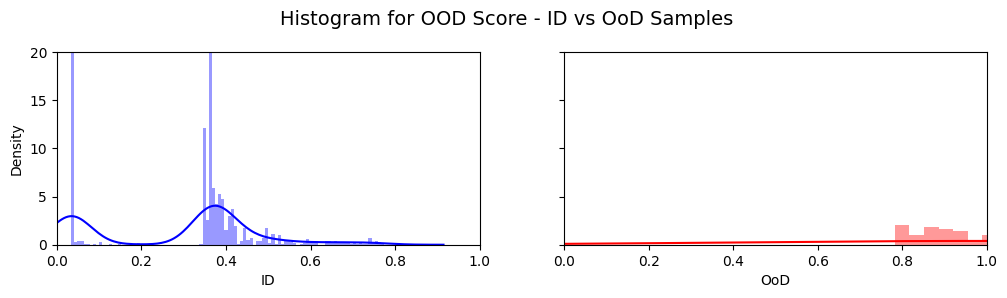

In [138]:
x1 = data_io.loc[(data_io["Log_Loss_ALL"] < gf1_Threshold), ['Log_Loss_ALL']]    # ID
x2 = data_io.loc[(data_io["Log_Loss_ALL"] >= gf1_Threshold), ['Log_Loss_ALL']]   # OoD


# plot
fig, axes = plt.subplots(1, 2, figsize=(12,2.5), sharey=True, sharex=True, dpi=100)
sns.distplot(x1, color="blue", ax=axes[0], axlabel='ID', kde=True, bins=100)
sns.distplot(x2, color="red", ax=axes[1], axlabel='OoD', kde=True, bins=100)
plt.xlim(0, 1)
plt.ylim(0, 20)


plt.suptitle('Histogram for OOD Score - ID vs OoD Samples', y=1.05, size=14)

In [139]:
# x1 = data_io.loc[(data_io["Log_Loss_ALL"] < gf1_Threshold), ['Log_Loss_ALL']]    # ID
# vizHist(x1, "blue")

In [140]:
x2 = data_io.loc[(data_io["Log_Loss_ALL"] >= gf1_Threshold), ['Log_Loss_ALL']]   # OoD
vizHist(x2, "red")

TypeError: vizHist() missing 2 required positional arguments: 'l1' and 'l2'

In [ ]:
x3 = data_io.loc[(data_io["Log_Loss_ALL"] >= 0), ['Log_Loss_ALL']]   # All
vizHist(x3, "green")

In [ ]:
def vizHist(x1, x2, l1, l2):
    fig, axes = plt.subplots(1, 2, figsize=(12,2.5), sharey=True, sharex=True, dpi=100)
    sns.distplot(x1, bins=100, color="blue", ax=axes[0],  axlabel=l1)
    sns.distplot(x2, bins=100, color="red", ax=axes[1],  axlabel=l2)
    plt.xlim(0, 5)
    plt.ylim(0, 5)

x1 = data_io.loc[(data_io["Log_Loss_ALL"] < gf1_Threshold), ['Log_Loss_ALL']]    # ID
x2 = data_io.loc[(data_io["Log_Loss_ALL"] >= gf1_Threshold), ['Log_Loss_ALL']]   # OoD
vizHist(x1, x2, "ID", "OoD")

In [ ]:
def vizHist2(x1, x2, l1, l2):
    fig, axes = plt.subplots(1, 2, figsize=(12,2.5), sharey=True, sharex=True, dpi=100)
    sns.distplot(x1, bins=100, color="blue", ax=axes[0],  axlabel=l1, kde = False)
    sns.distplot(x2, bins=100, color="red", ax=axes[1],  axlabel=l2, kde = False)
    plt.xlim(0, 5)
    plt.ylim(0, 180)

x1 = data_io.loc[(data_io["Log_Loss_ALL"] < gf1_Threshold), ['Log_Loss_ALL']]    # ID
x2 = data_io.loc[(data_io["Log_Loss_ALL"] >= gf1_Threshold), ['Log_Loss_ALL']]   # OoD
vizHist(x1, x2, "ID", "OoD")

## Experiments

In [ ]:
# confusion matrics results for 30 iterations for all experiments
df_CM = pd.DataFrame(columns=['Iter_ID', 'Method', 'Sen_train', 'Spe_train', 'Acc_train', 'Pre_train', 'F1_train',
                              'Sen_retrain', 'Spe_retrain', 'Acc_retrain', 'Pre_retrain', 'F1_retrain',
                              'Sen_test', 'Spe_test', 'Acc_test', 'Pre_test', 'F1_test',
                              'train_TN', 'train_FN', 'train_FP', 'train_TP',
                              'retrain_TN', 'retrain_FN', 'retrain_FP', 'retrain_TP',
                              'test_TN', 'test_FN', 'test_FP', 'test_TP'])

# sampel counts for training, test1idation, test2 and retrain for 30 iterations
df_Counts = pd.DataFrame(columns=['Iter_ID', 'Method', 'trainSet_nOOD', 'trainSet_OOD', 'reserveSet_nOOD', 'reserveSet_OOD',
                                   'retrainSet_nOOD', 'retrainSet_OOD', 'testSet_nOOD', 'testSet_OOD'])

df_KLD = pd.DataFrame(columns=['Iter_ID', 'Method', 'Features', 'KLD_t_t', 'KLD_rt_t', 'Types'])


# to identify ood score ranges for ID/OoD samples. ALso capture correctly classified and misclassified
# SampleType - ID or OoD.    TType - training, retraining, testing
df_OodRange = pd.DataFrame(columns=['Iter_ID', 'Method', 'TType', 'SampleType', 'MinOodScore','MaxOodScore'])

# To identify correctly classified and misclassified
#df_CMresults = pd.DataFrame(columns=['Iter_ID', 'Method', 'TType', 'TP','TN', 'FP', 'FN'])

### Baseline - Train - 70% ID, 0% OoD | Test - 30% ID, 30% OoD

In [ ]:
# This code is for experimenting
ID_set = data_io.loc[(data_io["Log_Loss_ALL"] < gf1_Threshold)] # ID samples
OoD_set = data_io.loc[(data_io["Log_Loss_ALL"] >= gf1_Threshold)] # OoD samples
bins_plt = jenkspy.jenks_breaks(OoD_set['Log_Loss_ALL'], n_classes=3)

#topGroup4 = bins_plt[0]  #  lowest value
topGroup4 = bins_plt[0]
topGroup3 = bins_plt[1]
topGroup2 = bins_plt[2]  # Highest value
topGroup1 = bins_plt[3]

print(topGroup1)
print(topGroup2)
print(topGroup3)
print(topGroup4)

print("   ")
print(OoD_set["Log_Loss_ALL"].max())
print(OoD_set["Log_Loss_ALL"].min())

In [ ]:
# experimentID
# total_IDpct - ID samples - split 70 train and 30 test
# total_OoDpct - OoD samples - split 70 reserve and 30 test
# lcl     - top N% to extract from Reserve to add to retraining based on Ood Score grouping

#def assignSample_trainClassifier(experimentID, total_IDpct, total_OoDpct, numIter):

def assignSample_trainClassifier(numIter):

    #global gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_test_dataF, gf1Smm_retrain_dataF

    #print(numIter)
    #-------------------------------------------------------------------------------------------------------------
    # PART-1: CREATE TRAINING, RESERVE and TEST Sets
    #-------------------------------------------------------------------------------------------------------------

    # STEP-1: Seperate ID and OoD Samples
    # Create training and test sets based on thresholded value

    data_io['LogLoss_Group'] = ''  # create a grouping field

    gf1Smm_ID_set = data_io.loc[(data_io["Log_Loss_ALL"] < gf1_Threshold)] # ID samples
    gf1Smm_OoD_set = data_io.loc[(data_io["Log_Loss_ALL"] >= gf1_Threshold)] # OoD samples

    # get counts
    gf1Smm_ID_set.shape  # -- ID samples
    gf1Smm_OoD_set.shape  # -- OoD Samles


    # STEP-2: ID Sample allocation for for Training and Testing
    # ID Samples: stratify ID samples by malignancy and manufacturer. Train 70% test 30%
    gf1Smm_ID_set = shuffle(gf1Smm_ID_set) # shuffle ID samples
    #gf1Smm_train_ID, gf1Smm_test_ID = train_test_split(gf1Smm_ID_set, test_size=0.3, stratify=gf1Smm_ID_set[["d_MalignancyDesc", "Manufacturer"]])
    gf1Smm_train_ID, gf1Smm_test_ID = train_test_split(gf1Smm_ID_set, test_size=0.3, stratify=gf1Smm_ID_set[["d_MalignancyDesc"]])



    # STEP-3: OoD Sample allocation for Reserve and Test - gf1Smm_OoD_set is OoD samples
    # OoD Samples: Group log loss value to groups for stratification add top G%

    #n_plt, bins_plt, patches = plt.hist(gf1Smm_OoD_set.Log_Loss_ALL, bins=4) # BASED ON HISTOGRAM
    bins_plt = jenkspy.jenks_breaks(gf1Smm_OoD_set['Log_Loss_ALL'], n_classes=3) # based on natural breaks


    # update group based on lower bound
    gf1Smm_OoD_set.loc[((gf1Smm_OoD_set["Log_Loss_ALL"] <= bins_plt[1])) , "LogLoss_Group"] = bins_plt[0]
    gf1Smm_OoD_set.loc[((gf1Smm_OoD_set["Log_Loss_ALL"] >bins_plt[1]) & (gf1Smm_OoD_set["Log_Loss_ALL"] <= bins_plt[2])) , "LogLoss_Group"] = bins_plt[1]
    gf1Smm_OoD_set.loc[((gf1Smm_OoD_set["Log_Loss_ALL"] >bins_plt[2]) & (gf1Smm_OoD_set["Log_Loss_ALL"] <= bins_plt[3])) , "LogLoss_Group"] = bins_plt[2]
    gf1Smm_OoD_set.loc[((gf1Smm_OoD_set["Log_Loss_ALL"] >bins_plt[3])) , "LogLoss_Group"] = bins_plt[3]

    #gf1Smm_OoD_set.to_csv("oodreserve.csv")
    topGroup4 = bins_plt[0]  # top group 4 - lowest value
    topGroup3 = bins_plt[1]  # top group 3
    topGroup2 = bins_plt[2]  # top group 2
    topGroup1 = bins_plt[3]  # top group 1 - Highest value


    # OoD Samples: stratify OoD samples by malignancy ood score grouping and manufacturer. Train 70% test 30%
    gf1Smm_OoD_set = shuffle(gf1Smm_OoD_set) # shuffle ID samples
    gf1Smm_reserve_OOD, gf1Smm_test_OOD = train_test_split(gf1Smm_OoD_set, test_size=0.3, stratify=gf1Smm_OoD_set[["d_MalignancyDesc", "LogLoss_Group"]])


    gf1Smm_train_dataF = gf1Smm_train_ID
    gf1Smm_reserve_dataF = gf1Smm_reserve_OOD
    gf1Smm_test_dataF = pd.concat([gf1Smm_test_ID, gf1Smm_test_OOD])



    #-------------------------------------------------------------------------------------------------------------
    # PART-2: TRAIN RF CLASSIFIER
    #-------------------------------------------------------------------------------------------------------------

    # STEP-1: # Select fields to use based on training set - IMPORTANT

    # I/P features: Design Features and SF, Manufacturer - added based on correlation values
    cols=['ConvexArea', 'Perimeter', 'EquivDiameter', 'MajorAxisLength', 'MinorAxisLength', 'Elongation', 'Compactness',
          'Eccentricity', 'Solidity', 'Extent', 'Circularity', 'x_3rdordermoment', 'Clustertendency', 'MaxProbability',
          'Entropy', 'ConvexPerimeter', 'Energy', 'RadialDistanceSD', 'gabormean_2_0', 'gabormean_2_1',
          'gabormean_0_0', 'gabormean_3_2', 'gabormean_3_0', 'dSpic2_5', 'dLob2_5', 'dCal3', 'dSubtl1_3', 'dIstru1',
          'dManuf_GE', 'dManuf_S', 'dManuf_P']


    gf1SmmX_train = gf1Smm_train_dataF[cols]
    gf1Smmy_train = gf1Smm_train_dataF['d_Malignancy']

    gf1SmmX_reserve = gf1Smm_reserve_dataF[cols]
    gf1Smmy_reserve = gf1Smm_reserve_dataF['d_Malignancy']

    gf1SmmX_test = gf1Smm_test_dataF[cols]
    gf1Smmy_test = gf1Smm_test_dataF['d_Malignancy']


    # STEP-2: Train Classifier and fit the classifier

    # cost:
    mCountA = len(data_io[data_io['d_Malignancy']== 1])
    bCountA = len(data_io[data_io['d_Malignancy']== 0])
    IR      = mCountA/bCountA

    rfExp_classifier = RandomForestClassifier(criterion='log_loss', max_depth=10, max_features=None,
                                              class_weight = {0: IR, 1: 1.5},
                                               max_leaf_nodes=3, min_samples_leaf=5, n_estimators=100,
                                               n_jobs=-1, random_state=42)


    rfExp_classifier.fit(gf1SmmX_train, gf1Smmy_train)

    # get terminal node
    #getLeafCount(rfExp_classifier, 'tree_2kA1_10_0.dot')



    #-------------------------------------------------------------------------------------------------------------
    # PART-3: EVALUATE TRAINING, TEST PERFORMANCE
    #-------------------------------------------------------------------------------------------------------------

    # STEP-1: Obtain Threshold using Training set for GMeans method

    # calculate roc curves - Thresold based on Training
    precision_f1Smm, recall_f1Smm, thresholds_pr_f1Smm = precision_recall_curve(gf1Smmy_train, rfExp_classifier.predict_proba(gf1Smm_train_dataF[gf1SmmX_train.columns])[:,1])

    # Calculate the f-score
    fscore_f1Smm = (2 * precision_f1Smm * recall_f1Smm) / (precision_f1Smm + recall_f1Smm)

    # Find the optimal threshold
    index_pr_f1Smm = np.argmax(fscore_f1Smm)
    gf1Smm_trainThreshold = round(thresholds_pr_f1Smm[index_pr_f1Smm], ndigits = 4)



    # STEP-2: Compute predicted Probabilities - first round (based on training)
    gf1Smm_train_dataF['Pred_prob1']   = rfExp_classifier.predict_proba(gf1Smm_train_dataF[gf1SmmX_train.columns])[:,1]
    gf1Smm_reserve_dataF['Pred_prob1'] = rfExp_classifier.predict_proba(gf1Smm_reserve_dataF[gf1SmmX_reserve.columns])[:,1]
    gf1Smm_test_dataF['Pred_prob1']    = rfExp_classifier.predict_proba(gf1Smm_test_dataF[gf1SmmX_test.columns])[:,1]


    # STEP-3: Compute Pred_Y based on the predicted probability and threshold
    #         if pred Pred_prob >= threshold, then Pred_Y = 1, else 0

    T = gf1Smm_trainThreshold
    #print("Train Threshold = ", str(T))

    # Train - compute Pred_Y
    gf1Smm_train_dataF["Pred_Y1"] = 0
    gf1Smm_train_dataF.loc[gf1Smm_train_dataF["Pred_prob1"] > T, "Pred_Y1"] = 1

    # Reserve - compute Pred_Y
    gf1Smm_reserve_dataF["Pred_Y1"] = 0
    gf1Smm_reserve_dataF.loc[gf1Smm_reserve_dataF["Pred_prob1"] > T, "Pred_Y1"] = 1

    # Tests - compute Pred_Y
    gf1Smm_test_dataF["Pred_Y1"] = 0
    gf1Smm_test_dataF.loc[gf1Smm_test_dataF["Pred_prob1"] > T, "Pred_Y1"] = 1


    # check if the variables were created and populated correctly
    gf1Smm_train_dataF[['noduleID', 'd_Malignancy','Pred_prob1', 'Pred_Y1']].head(10)
    gf1Smm_reserve_dataF[['noduleID', 'd_Malignancy','Pred_prob1', 'Pred_Y1']].head(10)
    gf1Smm_test_dataF[['noduleID', 'd_Malignancy','Pred_prob1', 'Pred_Y1']].head(10)


    # Step-4: Confusion matrix for training and test set
    # funcation to compute and return values for - training and test performance
    Sen_gf1Smm_train, Spe_gf1Smm_train, Acc_gf1Smm_train, Pre_gf1Smm_train, F1_gf1Smm_train, train_TN, train_FN, train_FP, train_TP = confMatrixResults(gf1Smm_train_dataF.d_Malignancy, gf1Smm_train_dataF.Pred_Y1)
    Sen_gf1Smm_test, Spe_gf1Smm_test, Acc_gf1Smm_test, Pre_gf1Smm_test, F1_gf1Smm_test, test_TN, test_FN, test_FP, test_TP = confMatrixResults(gf1Smm_test_dataF.d_Malignancy, gf1Smm_test_dataF.Pred_Y1)



    # train, reserve, test samples, last 2 for counts
    return gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_test_dataF, gf1Smm_test_ID, gf1Smm_test_OOD, topGroup1, topGroup2, topGroup3, topGroup4, gf1SmmX_reserve, gf1Smmy_reserve, gf1SmmX_test, gf1Smmy_test, Sen_gf1Smm_train, Spe_gf1Smm_train, Acc_gf1Smm_train, Pre_gf1Smm_train, F1_gf1Smm_train, train_TN, train_FN, train_FP, train_TP, test_TN, test_FN, test_FP, test_TP

In [ ]:

def createRetrainSet(gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_test_dataF, gf1Smm_test_ID, gf1Smm_test_OOD,
                      topGroup1, topGroup2, topGroup3, topGroup4, gf1SmmX_reserve, gf1Smmy_reserve, gf1SmmX_test,
                      gf1Smmy_test, Sen_gf1Smm_train, Spe_gf1Smm_train, Acc_gf1Smm_train, Pre_gf1Smm_train,
                      F1_gf1Smm_train, train_TN, train_FN, train_FP, train_TP, test_TN, test_FN, test_FP, test_TP,
                      numIter):

    #print(topGroup1, topGroup2, topGroup3, topGroup4)
    #print("itemID --- createRetrainSet = ", str(numIter))

    #-------------------------------------------------------------------------------------------------------------
    # PART-4: Create retraining sample and retrain classifier based on OoD Score group
    #-------------------------------------------------------------------------------------------------------------

    # SETP-1: Extract the OOD Samples from test1 Set Added to Training

    # TOP GROUP 0
    # Add top group first topGroup1
    experimentID = 'Experiment1_0'

    gf1Smm_oodSamples_toAdd = gf1Smm_reserve_dataF.loc[gf1Smm_reserve_dataF['Log_Loss_ALL'] < topGroup4] # on OODs
    gf1Smm_oodSamples_toAdd.shape
    #gf1Smm_reserve_dataF.to_csv("reserve.csv")

    # create retraining set
    gf1Smm_retrain_dataF = pd.concat([gf1Smm_train_dataF, gf1Smm_oodSamples_toAdd])

    # call retrainClassifier
    retrainClassifier(gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_retrain_dataF, gf1Smm_test_dataF, gf1Smm_test_ID,
                      gf1Smm_test_OOD, topGroup1, topGroup2, topGroup3, topGroup4, gf1SmmX_reserve, gf1Smmy_reserve,
                      gf1SmmX_test, gf1Smmy_test, Sen_gf1Smm_train, Spe_gf1Smm_train, Acc_gf1Smm_train, Pre_gf1Smm_train,
                      F1_gf1Smm_train, train_TN, train_FN, train_FP, train_TP, test_TN, test_FN, test_FP, test_TP,
                      experimentID, numIter, gf1Smm_oodSamples_toAdd, 'tree_2kA1_10_x.dot')

    # KLD Values
    KLD_cummValues(numIter, experimentID, gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_retrain_dataF, gf1Smm_test_dataF, "All")
    KLD_cummValues(numIter, experimentID, gf1Smm_oodSamples_toAdd, gf1Smm_oodSamples_toAdd, gf1Smm_oodSamples_toAdd, gf1Smm_test_OOD, "OOD")

    # Distribution
    x1 = gf1Smm_train_dataF.loc[(gf1Smm_train_dataF["Log_Loss_ALL"] >=0 ), ['Log_Loss_ALL']]    # Train
    x2 = gf1Smm_test_dataF.loc[(gf1Smm_test_dataF["Log_Loss_ALL"] >=0 ), ['Log_Loss_ALL']]      # Test
    vizHist(x1, x2, "Train", "Test")
    vizHist2(x1, x2, "Train", "Test")



    # TOP GROUP 1
    # Add top group first topGroup1
    experimentID = 'Experiment1_1'

    gf1Smm_oodSamples_toAdd = gf1Smm_reserve_dataF.loc[gf1Smm_reserve_dataF['Log_Loss_ALL'] <= topGroup3]
    gf1Smm_oodSamples_toAdd.shape

    # create retraining set
    gf1Smm_retrain_dataF = pd.concat([gf1Smm_train_dataF, gf1Smm_oodSamples_toAdd])

    # call retrainClassifier
    retrainClassifier(gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_retrain_dataF, gf1Smm_test_dataF, gf1Smm_test_ID,
                      gf1Smm_test_OOD, topGroup1, topGroup2, topGroup3, topGroup4, gf1SmmX_reserve, gf1Smmy_reserve,
                      gf1SmmX_test, gf1Smmy_test, Sen_gf1Smm_train, Spe_gf1Smm_train, Acc_gf1Smm_train, Pre_gf1Smm_train,
                      F1_gf1Smm_train, train_TN, train_FN, train_FP, train_TP, test_TN, test_FN, test_FP, test_TP,
                      experimentID, numIter, gf1Smm_oodSamples_toAdd, 'tree_2kA1_10_1.dot')

    # KLD Values
    KLD_cummValues(numIter, experimentID, gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_retrain_dataF, gf1Smm_test_dataF, "All")
    KLD_cummValues(numIter, experimentID, gf1Smm_oodSamples_toAdd, gf1Smm_oodSamples_toAdd, gf1Smm_oodSamples_toAdd, gf1Smm_test_OOD, "OOD")

    # Distribution
    x1 = gf1Smm_retrain_dataF.loc[(gf1Smm_retrain_dataF["Log_Loss_ALL"] >=0 ), ['Log_Loss_ALL']]    # Retrain
    x2 = gf1Smm_test_dataF.loc[(gf1Smm_test_dataF["Log_Loss_ALL"] >=0 ), ['Log_Loss_ALL']]          # Test
    vizHist(x1, x2, "Retrain-1", "Test")
    vizHist2(x1, x2, "Retrain-1", "Test")



    # TOP GROUP 2
    # Add top group first topGroup2
    experimentID = 'Experiment1_2'

    gf1Smm_oodSamples_toAdd = gf1Smm_reserve_dataF.loc[gf1Smm_reserve_dataF['Log_Loss_ALL'] <= topGroup2]
    gf1Smm_oodSamples_toAdd.shape

    # create retraining set
    gf1Smm_retrain_dataF = pd.concat([gf1Smm_train_dataF, gf1Smm_oodSamples_toAdd])

    # call retrainClassifier
    retrainClassifier(gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_retrain_dataF, gf1Smm_test_dataF, gf1Smm_test_ID,
                      gf1Smm_test_OOD, topGroup1, topGroup2, topGroup3, topGroup4, gf1SmmX_reserve, gf1Smmy_reserve,
                      gf1SmmX_test, gf1Smmy_test, Sen_gf1Smm_train, Spe_gf1Smm_train, Acc_gf1Smm_train, Pre_gf1Smm_train,
                      F1_gf1Smm_train, train_TN, train_FN, train_FP, train_TP, test_TN, test_FN, test_FP, test_TP,
                      experimentID, numIter, gf1Smm_oodSamples_toAdd, 'tree_2kA1_10_2.dot')

    # KLD Values
    KLD_cummValues(numIter, experimentID, gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_retrain_dataF, gf1Smm_test_dataF, "All")
    KLD_cummValues(numIter, experimentID, gf1Smm_oodSamples_toAdd, gf1Smm_oodSamples_toAdd, gf1Smm_oodSamples_toAdd, gf1Smm_test_OOD, "OOD")


    # Distribution
    x1 = gf1Smm_retrain_dataF.loc[(gf1Smm_retrain_dataF["Log_Loss_ALL"] >=0 ), ['Log_Loss_ALL']]    # Retrain
    x2 = gf1Smm_test_dataF.loc[(gf1Smm_test_dataF["Log_Loss_ALL"] >=0 ), ['Log_Loss_ALL']]          # Test
    vizHist(x1, x2, "Retrain-2", "Test")
    vizHist2(x1, x2, "Retrain-2", "Test")



    # TOP GROUP 3
    # Add top group first topGroup3
    experimentID = 'Experiment1_3'

    gf1Smm_oodSamples_toAdd = gf1Smm_reserve_dataF.loc[gf1Smm_reserve_dataF['Log_Loss_ALL'] <= topGroup1]
    gf1Smm_oodSamples_toAdd.shape

    # create retraining set
    gf1Smm_retrain_dataF = pd.concat([gf1Smm_train_dataF, gf1Smm_oodSamples_toAdd])

    # call retrainClassifier
    retrainClassifier(gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_retrain_dataF, gf1Smm_test_dataF, gf1Smm_test_ID,
                      gf1Smm_test_OOD, topGroup1, topGroup2, topGroup3, topGroup4, gf1SmmX_reserve, gf1Smmy_reserve,
                      gf1SmmX_test, gf1Smmy_test, Sen_gf1Smm_train, Spe_gf1Smm_train, Acc_gf1Smm_train, Pre_gf1Smm_train,
                      F1_gf1Smm_train, train_TN, train_FN, train_FP, train_TP, test_TN, test_FN, test_FP, test_TP,
                      experimentID, numIter, gf1Smm_oodSamples_toAdd, 'tree_2kA1_10_3.dot')

    # KLD Values
    KLD_cummValues(numIter, experimentID, gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_retrain_dataF, gf1Smm_test_dataF, "All")
    KLD_cummValues(numIter, experimentID, gf1Smm_oodSamples_toAdd, gf1Smm_oodSamples_toAdd, gf1Smm_oodSamples_toAdd, gf1Smm_test_OOD, "OOD")


    # Distribution
    x1 = gf1Smm_retrain_dataF.loc[(gf1Smm_retrain_dataF["Log_Loss_ALL"] >=0 ), ['Log_Loss_ALL']]    # Retrain
    x2 = gf1Smm_test_dataF.loc[(gf1Smm_test_dataF["Log_Loss_ALL"] >=0 ), ['Log_Loss_ALL']]          # Test
    vizHist(x1, x2, "Retrain-3", "Test")
    vizHist2(x1, x2, "Retrain-3", "Test")


In [ ]:

def retrainClassifier(gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_retrain_dataF, gf1Smm_test_dataF, gf1Smm_test_ID,
                      gf1Smm_test_OOD, topGroup1, topGroup2, topGroup3, topGroup4, gf1SmmX_reserve, gf1Smmy_reserve,
                      gf1SmmX_test, gf1Smmy_test, Sen_gf1Smm_train, Spe_gf1Smm_train, Acc_gf1Smm_train, Pre_gf1Smm_train,
                      F1_gf1Smm_train, train_TN, train_FN, train_FP, train_TP, test_TN, test_FN, test_FP, test_TP,
                      experimentID, numIter, gf1Smm_oodSamples_toAdd, tree_fileName):

    global df_CM, df_Counts, df_KLD, df_OodRange, df_RetrainOoD


    #-------------------------------------------------------------------------------------------------------------
    # PART-5: Retraining Classifier
    #-------------------------------------------------------------------------------------------------------------

    # STEP-1: Fit the model
    # set columns for retraining model. Feature list is same as original/full training model

    cols=['ConvexArea', 'Perimeter', 'EquivDiameter', 'MajorAxisLength', 'MinorAxisLength', 'Elongation', 'Compactness',
          'Eccentricity', 'Solidity', 'Extent', 'Circularity', 'x_3rdordermoment', 'Clustertendency', 'MaxProbability',
          'Entropy', 'ConvexPerimeter', 'Energy', 'RadialDistanceSD', 'gabormean_2_0', 'gabormean_2_1',
          'gabormean_0_0', 'gabormean_3_2', 'gabormean_3_0', 'dSpic2_5', 'dLob2_5', 'dCal3', 'dSubtl1_3', 'dIstru1',
          'dManuf_GE', 'dManuf_S', 'dManuf_P']


    gf1SmmX_retrain = gf1Smm_retrain_dataF[cols]
    gf1Smmy_retrain = gf1Smm_retrain_dataF['d_Malignancy']



    # retrain classifier and fit the classifier

    # cost:
    mCountA = len(data_io[data_io['d_Malignancy']== 1])
    bCountA = len(data_io[data_io['d_Malignancy']== 0])
    IR      = mCountA/bCountA

    rfExp_reTrain_classifier = RandomForestClassifier(criterion='log_loss', max_depth=10, max_features=None,
                                                      class_weight = {0: IR, 1: 1.5},
                                                       max_leaf_nodes=3, min_samples_leaf=5, n_estimators=100,
                                                       n_jobs=-1, random_state=42)

    rfExp_reTrain_classifier.fit(gf1SmmX_retrain, gf1Smmy_retrain)

    # get terminal node
    #getLeafCount(rfExp_reTrain_classifier, tree_fileName)


    # STEP-2: Write Counts for Training, reserve, test Set Counts to dataframe
    nOOD_Train  = len(gf1Smm_train_dataF)
    OOD_Train   = 0
    nOOD_reserve  = 0
    OOD_reserve   = len(gf1Smm_reserve_dataF)
    nOOD_test  = len(gf1Smm_test_ID)
    OOD_test   = len(gf1Smm_test_OOD)
    nOODRetrain = nOOD_Train
    OOD_Retrain = len(gf1Smm_oodSamples_toAdd)


    df_Counts = df_Counts.append({'Iter_ID': numIter , 'Method': experimentID,
                                   'trainSet_nOOD': nOOD_Train ,  'trainSet_OOD': OOD_Train,
                                   'reserveSet_nOOD': nOOD_reserve , 'reserveSet_OOD': OOD_reserve ,
                                   'retrainSet_nOOD': nOODRetrain , 'retrainSet_OOD': OOD_Retrain ,
                                   'testSet_nOOD': nOOD_test , 'testSet_OOD': OOD_test }, ignore_index=True)


    # Step-3: Get OoD Score ranges for ID and OoD Samples for each experiment
    df_OodRange = df_OodRange.append({'Iter_ID': numIter, 'Method': experimentID,
                                      'TType': 'Train', 'SampleType': 'ID',
                                      'MinOodScore': gf1Smm_train_dataF['Log_Loss_ALL'].min() ,
                                      'MaxOodScore': gf1Smm_train_dataF['Log_Loss_ALL'].max() }, ignore_index=True)

    df_OodRange = df_OodRange.append({'Iter_ID': numIter, 'Method': experimentID,
                                      'TType': 'Retrain', 'SampleType': 'ID',
                                      'MinOodScore': gf1Smm_train_dataF['Log_Loss_ALL'].min() ,
                                      'MaxOodScore': gf1Smm_train_dataF['Log_Loss_ALL'].max() }, ignore_index=True)

    df_OodRange = df_OodRange.append({'Iter_ID': numIter, 'Method': experimentID,
                                      'TType': 'Retrain', 'SampleType': 'OOD',
                                      'MinOodScore': gf1Smm_oodSamples_toAdd['Log_Loss_ALL'].min() ,
                                      'MaxOodScore': gf1Smm_oodSamples_toAdd['Log_Loss_ALL'].max() }, ignore_index=True)

    df_OodRange = df_OodRange.append({'Iter_ID': numIter, 'Method': experimentID,
                                      'TType': 'Test', 'SampleType': 'ID',
                                      'MinOodScore': gf1Smm_test_ID['Log_Loss_ALL'].min() ,
                                      'MaxOodScore': gf1Smm_test_ID['Log_Loss_ALL'].max() }, ignore_index=True)

    df_OodRange = df_OodRange.append({'Iter_ID': numIter, 'Method': experimentID,
                                      'TType': 'Test', 'SampleType': 'OOD',
                                      'MinOodScore': gf1Smm_test_OOD['Log_Loss_ALL'].min() ,
                                      'MaxOodScore': gf1Smm_test_OOD['Log_Loss_ALL'].max() }, ignore_index=True)


    #-------------------------------------------------------------------------------------------------------------
    # PART-6: Retraining Classifier - Compute performance on retraining and test sets
    #-------------------------------------------------------------------------------------------------------------

    # STEP-1: Compute predicted probabilities

    gf1Smm_retrain_dataF['Pred_prob2'] = rfExp_reTrain_classifier.predict_proba(gf1Smm_retrain_dataF[gf1SmmX_retrain.columns])[:,1]
    gf1Smm_reserve_dataF['Pred_prob2'] = rfExp_reTrain_classifier.predict_proba(gf1Smm_reserve_dataF[gf1SmmX_reserve.columns])[:,1]
    gf1Smm_test_dataF['Pred_prob2'] = rfExp_reTrain_classifier.predict_proba(gf1Smm_test_dataF[gf1SmmX_test.columns])[:,1]

    # calculate roc curves - Thresold based on Training
    precision_retrainf1Smm, recall_retrainf1Smm, thresholds_pr_retrainf1Smm = precision_recall_curve(gf1Smmy_retrain, rfExp_reTrain_classifier.predict_proba(gf1Smm_retrain_dataF[gf1SmmX_retrain.columns])[:,1])

    # Calculate the f-score
    fscore_retrainf1Smm = (2 * precision_retrainf1Smm * recall_retrainf1Smm) / (precision_retrainf1Smm + recall_retrainf1Smm)

    # Find the optimal threshold
    index_pr_retrainf1Smm = np.argmax(fscore_retrainf1Smm)
    gf1Smm_retrainThreshold = round(thresholds_pr_retrainf1Smm[index_pr_retrainf1Smm], ndigits = 4)



    T_new = gf1Smm_retrainThreshold
    #print("Retrain Threshold = ", str(T_new), " for ", str(experimentID))


    # Step-2: Retrain - compute Pred_Y
    gf1Smm_retrain_dataF["Pred_Y2"] = 0
    gf1Smm_retrain_dataF.loc[gf1Smm_retrain_dataF["Pred_prob2"] > T_new, "Pred_Y2"] = 1

    # test - compute Pred_Y
    gf1Smm_test_dataF["Pred_Y2"] = 0
    gf1Smm_test_dataF.loc[gf1Smm_test_dataF["Pred_prob2"] > T_new, "Pred_Y2"] = 1


    # Reserve - compute Pred_Y --- DONE FOR Reserve SO THAT COLUMNS ARE IN THE SAME ORDER FOR ALL 3 SETS
    gf1Smm_reserve_dataF["Pred_Y2"] = 0
    gf1Smm_reserve_dataF.loc[gf1Smm_reserve_dataF["Pred_prob2"] > T_new, "Pred_Y2"] = 1


    # Export to excel for checking misclassifications
#     myPath = "./_SubsetsCreated/RF/RF_New_FHLOne_Agr/Train_" + str(experimentID) + "_logloss.csv"
#     gf1Smm_train_dataF.to_csv(myPath)
#     myPath = "./_SubsetsCreated/RF/RF_New_FHLOne_Agr/Retrain_" + str(experimentID) + "_logloss.csv"
#     gf1Smm_retrain_dataF.to_csv(myPath)
#     myPath = "./_SubsetsCreated/RF/RF_New_FHLOne_Agr/Test_" + str(experimentID) + "_logloss.csv"
#     gf1Smm_test_dataF.to_csv(myPath)


    # Step-3: Confusion matrix for retraining and test2 set
    # funcation to compute and return test1ues  retrain and test2
    Sen_gf1Smm_retrain, Spe_gf1Smm_retrain, Acc_gf1Smm_retrain, Pre_gf1Smm_retrain, F1_gf1Smm_retrain,  retrain_TN, retrain_FN, retrain_FP, retrain_TP  = confMatrixResults(gf1Smm_retrain_dataF.d_Malignancy, gf1Smm_retrain_dataF.Pred_Y2)
    Sen_gf1Smm_test, Spe_gf1Smm_test, Acc_gf1Smm_test, Pre_gf1Smm_test, F1_gf1Smm_test, test_TN, test_FN, test_FP, test_TP  = confMatrixResults(gf1Smm_test_dataF.d_Malignancy, gf1Smm_test_dataF.Pred_Y2)


    #-------------------------------------------------------------------------------------------------------------
    # PART-7: Write all performance indicators to dataframe. Compute Average and CI
    #         Note: only step-1 variable list needs to be changed
    #-------------------------------------------------------------------------------------------------------------

    # Step-1: write results to dataframe
    df_CM = df_CM.append({'Iter_ID': numIter , 'Method': experimentID,
                              'Sen_train': Sen_gf1Smm_train , 'Spe_train': Spe_gf1Smm_train , 'Acc_train': Acc_gf1Smm_train ,
                              'Pre_train': Pre_gf1Smm_train , 'F1_train': F1_gf1Smm_train,
                              'Sen_retrain': Sen_gf1Smm_retrain , 'Spe_retrain': Spe_gf1Smm_retrain , 'Acc_retrain': Acc_gf1Smm_retrain ,
                              'Pre_retrain': Pre_gf1Smm_retrain , 'F1_retrain' : F1_gf1Smm_retrain,
                              'Sen_test': Sen_gf1Smm_test , 'Spe_test': Spe_gf1Smm_test , 'Acc_test': Acc_gf1Smm_test ,
                              'Pre_test': Pre_gf1Smm_test , 'F1_test': F1_gf1Smm_test,
                              'train_TN' : train_TN, 'train_FN': train_FN, 'train_FP': train_FP, 'train_TP': train_TP,
                              'retrain_TN': retrain_TN, 'retrain_FN':retrain_FN, 'retrain_FP':retrain_FP, 'retrain_TP': retrain_TP,
                              'test_TN': test_TN, 'test_FN': test_FN, 'test_FP': test_FP, 'test_TP': test_TP }, ignore_index=True)


    #return gf1Smm_retrain_dataF

In [ ]:
# Initialize KLD arrays
kl_divergenceALL_T_T1 = []
kl_divergenceALL_RT_T2 = []
kl_featuresALL_T_T1 = []
kl_featuresALL_RT_T2 = []

for i in range(1, 31):
    numIter = i
    # tran classifier
    gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_test_dataF, gf1Smm_test_ID, gf1Smm_test_OOD, topGroup1, topGroup2, topGroup3, topGroup4, gf1SmmX_reserve, gf1Smmy_reserve, gf1SmmX_test, gf1Smmy_test, Sen_gf1Smm_train, Spe_gf1Smm_train, Acc_gf1Smm_train, Pre_gf1Smm_train, F1_gf1Smm_train, train_TN, train_FN, train_FP, train_TP, test_TN, test_FN, test_FP, test_TP = assignSample_trainClassifier(numIter)

    #print("itemID --- FUNCTION = ", str(numIter))
    # create retrain set and retrain classifier
    createRetrainSet(gf1Smm_train_dataF, gf1Smm_reserve_dataF, gf1Smm_test_dataF, gf1Smm_test_ID, gf1Smm_test_OOD, topGroup1, topGroup2, topGroup3, topGroup4, gf1SmmX_reserve, gf1Smmy_reserve, gf1SmmX_test, gf1Smmy_test, Sen_gf1Smm_train, Spe_gf1Smm_train, Acc_gf1Smm_train, Pre_gf1Smm_train, F1_gf1Smm_train, train_TN, train_FN, train_FP, train_TP, test_TN, test_FN, test_FP, test_TP, numIter)


In [ ]:
#  COMPUTE COUNTS, PERFORMANCE, KLD
# SHow counts and Performance indicators

len_exp = len(df_CM["Method"].unique())
experiments = df_CM["Method"].unique()


for j in range (1, len_exp+1):
    experimentID = experiments[j-1]

    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    getCounts(df_Counts, experimentID)
    getPerformance(df_CM, experimentID)
    getOoDScoreRange(df_OodRange, experimentID)


    # Initialize KLD arrays
    kl_divergenceALL_T_T1 = []
    kl_divergenceALL_RT_T2 = []
    kl_featuresALL_T_T1 = []
    kl_featuresALL_RT_T2 = []

    # Compute average for KLD features
    # 'Experiment1_0' - is the original training/testing -- to compare all experiments with
    kl_divergenceALL_T_T1, kl_divergenceALL_RT_T2, kl_featuresALL_T_T1, kl_featuresALL_RT_T2 = avgKLDbyFeature('Experiment1_0', experimentID, "All")
    kl_divergenceALL_T_T1_ood, kl_divergenceALL_RT_T2_ood, kl_featuresALL_T_T1_ood, kl_featuresALL_RT_T2_ood = avgKLDbyFeature('Experiment1_0', experimentID, "OOD")

    # KLD Cumulative Graph
    KLD_cummulativeGraph(kl_divergenceALL_T_T1, kl_divergenceALL_RT_T2, kl_featuresALL_T_T1, kl_featuresALL_RT_T2)

    #KLD CI
    getKLDRange(experimentID, "All")
    getKLDRange(experimentID, "OOD")

    print(" ")
    print(" ")


#### Significant Test - 2-tail (if Difference is Significant)

In [ ]:
Acc_test0 = df_CM.where((df_CM.Method== "Experiment1_0")).dropna()['Acc_test']
Acc_test1 = df_CM.where((df_CM.Method== "Experiment1_1")).dropna()['Acc_test']
Acc_test2 = df_CM.where((df_CM.Method== "Experiment1_2")).dropna()['Acc_test']
Acc_test3 = df_CM.where((df_CM.Method== "Experiment1_3")).dropna()['Acc_test']
Acc_test4 = df_CM.where((df_CM.Method== "Experiment1_4")).dropna()['Acc_test']


stat1, p_value1 = stats.ttest_ind(Acc_test0, Acc_test1)
sigDesc1 = sigPval(p_value1)
stat2, p_value2 = stats.ttest_ind(Acc_test0, Acc_test2)
sigDesc2 = sigPval(p_value2)
stat3, p_value3 = stats.ttest_ind(Acc_test0, Acc_test3)
sigDesc3 = sigPval(p_value3)
stat4, p_value4 = stats.ttest_ind(Acc_test0, Acc_test4)
sigDesc4 = sigPval(p_value4)

print("Test - Satt. Sig.")
print('ACC - Test-Baseline and Test 10: p_value=%.4f - %s' % (p_value1, sigDesc1))
print('ACC - Test-Baseline and Test 20: p_value=%.4f - %s' % (p_value2, sigDesc2))
print('ACC - Test-Baseline and Test 30: p_value=%.4f - %s' % (p_value3, sigDesc3))
print('ACC - Test-Baseline and Test 40: p_value=%.4f - %s' % (p_value4, sigDesc4))

#### Significant Test - 1-tail -- TRAIN and TEST -- (if Difference is sig. more than what you are comparing it with)

In [ ]:
# TEST
Acc_test0 = df_CM.where((df_CM.Method== "Experiment1_0")).dropna()['Acc_test']
Acc_test1 = df_CM.where((df_CM.Method== "Experiment1_1")).dropna()['Acc_test']
Acc_test2 = df_CM.where((df_CM.Method== "Experiment1_2")).dropna()['Acc_test']
Acc_test3 = df_CM.where((df_CM.Method== "Experiment1_3")).dropna()['Acc_test']

# test0 with all others
#ttest_1samp
stat1, p_value1 = stats.ttest_ind(Acc_test0, Acc_test1, alternative='less')
sigDesc1 = sigPval(p_value1)
stat2, p_value2 = stats.ttest_ind(Acc_test0, Acc_test2, alternative='less')
sigDesc2 = sigPval(p_value2)
stat3, p_value3 = stats.ttest_ind(Acc_test0, Acc_test3, alternative='less')
sigDesc3 = sigPval(p_value3)

# between tests 1, 2, 3, 4
stat5, p_value5 = stats.ttest_ind(Acc_test1, Acc_test2, alternative='less')  # 1 & 2
sigDesc5 = sigPval(p_value5)
stat6, p_value6 = stats.ttest_ind(Acc_test2, Acc_test3, alternative='less')  # 2 & 3
sigDesc6 = sigPval(p_value6)


print("TEST")
print("Test 1, 2, 3, 4 > Test 0 --- Sat. Sig. Greater?")
print('ACC - Test 0 and Test 1: p_value=%.4f - %s' % (p_value1, sigDesc1))
print('ACC - Test 0 and Test 2: p_value=%.4f - %s' % (p_value2, sigDesc2))
print('ACC - Test 0 and Test 3: p_value=%.4f - %s' % (p_value3, sigDesc3))

print(" ")
print("Test 1<2<3<4  --- Sat. Sig. Greater?")
print('ACC - Test 1 & 2: p_value=%.4f - %s' % (p_value5, sigDesc5))
print('ACC - Test 2 & 2: p_value=%.4f - %s' % (p_value6, sigDesc6))

In [ ]:
# TRAIN
Acc_train0 = df_CM.where((df_CM.Method== "Experiment1_0")).dropna()['Acc_train']
Acc_train1 = df_CM.where((df_CM.Method== "Experiment1_1")).dropna()['Acc_retrain']
Acc_train2 = df_CM.where((df_CM.Method== "Experiment1_2")).dropna()['Acc_retrain']
Acc_train3 = df_CM.where((df_CM.Method== "Experiment1_3")).dropna()['Acc_retrain']

# train0 with all others
stat1, p_value1 = stats.ttest_ind(Acc_train0, Acc_train1, alternative='greater')
sigDesc1 = sigPval(p_value1)
stat2, p_value2 = stats.ttest_ind(Acc_train0, Acc_train2, alternative='greater')
sigDesc2 = sigPval(p_value2)
stat3, p_value3 = stats.ttest_ind(Acc_train0, Acc_train3, alternative='greater')
sigDesc3 = sigPval(p_value3)

# between train 1, 2, 3, 4
stat5, p_value5 = stats.ttest_ind(Acc_train1, Acc_train2, alternative='greater')  # 1 & 2
sigDesc5 = sigPval(p_value5)
stat6, p_value6 = stats.ttest_ind(Acc_train2, Acc_train3, alternative='greater')  # 2 & 3
sigDesc6 = sigPval(p_value6)


print("TRAIN")
print("Retrain 1, 2, 3, 4 > Train 0 --- Sat. Sig. Greater?")
print('ACC - Train 0 and Retrain 1: p_value=%.4f - %s' % (p_value1, sigDesc1))
print('ACC - Train 0 and Retrain 2: p_value=%.4f - %s' % (p_value2, sigDesc2))
print('ACC - Train 0 and Retrain 3: p_value=%.4f - %s' % (p_value3, sigDesc3))

print(" ")
print("Retrain 1<2<3<4  --- Sat. Sig. Greater?")
print('ACC - Retrain 1 & 2: p_value=%.4f - %s' % (p_value5, sigDesc5))
print('ACC - Retrain 2 & 2: p_value=%.4f - %s' % (p_value6, sigDesc6))

In [ ]:
# KLD - All samples
kld_train0 = df_KLD.where((df_KLD['Method'] == "Experiment1_0") & (df_KLD['Types'] == "All")).dropna()['KLD_t_t']
kld_train1 = df_KLD.where((df_KLD['Method'] == "Experiment1_1") & (df_KLD['Types'] == "All")).dropna()['KLD_rt_t']
kld_train2 = df_KLD.where((df_KLD['Method'] == "Experiment1_2") & (df_KLD['Types'] == "All")).dropna()['KLD_rt_t']
kld_train3 = df_KLD.where((df_KLD['Method'] == "Experiment1_3") & (df_KLD['Types'] == "All")).dropna()['KLD_rt_t']

# train0 with all others
stat1, p_value1 = stats.ttest_ind(kld_train0, kld_train1, alternative='greater')
sigDesc1 = sigPval(p_value1)
stat2, p_value2 = stats.ttest_ind(kld_train0, kld_train2, alternative='greater')
sigDesc2 = sigPval(p_value2)
stat3, p_value3 = stats.ttest_ind(kld_train0, kld_train3, alternative='greater')
sigDesc3 = sigPval(p_value3)

# between train 1, 2, 3, 4
stat5, p_value5 = stats.ttest_ind(kld_train1, kld_train2, alternative='greater')  # 1 & 2
sigDesc5 = sigPval(p_value5)
stat6, p_value6 = stats.ttest_ind(kld_train2, kld_train3, alternative='greater')  # 2 & 3
sigDesc6 = sigPval(p_value6)


print("TRAIN")
print("Retrain 1, 2, 3, 4 > Train 0 --- Sat. Sig. Greater?")
print('kld - Train 0 and Retrain 1: p_value=%.4f - %s' % (p_value1, sigDesc1))
print('kld - Train 0 and Retrain 2: p_value=%.4f - %s' % (p_value2, sigDesc2))
print('kld - Train 0 and Retrain 3: p_value=%.4f - %s' % (p_value3, sigDesc3))


print(" ")
print("Retrain 1<2<3<4  --- Sat. Sig. Greater?")
print('kld - Retrain 1 & 2: p_value=%.4f - %s' % (p_value5, sigDesc5))
print('kld - Retrain 2 & 2: p_value=%.4f - %s' % (p_value6, sigDesc6))

In [ ]:
# KLD - All samples
kld_train0 = df_KLD.where((df_KLD['Method'] == "Experiment1_0") & (df_KLD['Types'] == "OOD")).dropna()['KLD_t_t']
kld_train1 = df_KLD.where((df_KLD['Method'] == "Experiment1_1") & (df_KLD['Types'] == "OOD")).dropna()['KLD_rt_t']
kld_train2 = df_KLD.where((df_KLD['Method'] == "Experiment1_2") & (df_KLD['Types'] == "OOD")).dropna()['KLD_rt_t']
kld_train3 = df_KLD.where((df_KLD['Method'] == "Experiment1_3") & (df_KLD['Types'] == "OOD")).dropna()['KLD_rt_t']

# train0 with all others
stat1, p_value1 = stats.ttest_ind(kld_train0, kld_train1, alternative='greater')
sigDesc1 = sigPval(p_value1)
stat2, p_value2 = stats.ttest_ind(kld_train0, kld_train2, alternative='greater')
sigDesc2 = sigPval(p_value2)
stat3, p_value3 = stats.ttest_ind(kld_train0, kld_train3, alternative='greater')
sigDesc3 = sigPval(p_value3)

# between train 1, 2, 3, 4
stat5, p_value5 = stats.ttest_ind(kld_train1, kld_train2, alternative='greater')  # 1 & 2
sigDesc5 = sigPval(p_value5)
stat6, p_value6 = stats.ttest_ind(kld_train2, kld_train3, alternative='greater')  # 2 & 3
sigDesc6 = sigPval(p_value6)


print("TRAIN")
print("Retrain 1, 2, 3, 4 > Train 0 --- Sat. Sig. Greater?")
print('kld - Train 0 and Retrain 1: p_value=%.4f - %s' % (p_value1, sigDesc1))
print('kld - Train 0 and Retrain 2: p_value=%.4f - %s' % (p_value2, sigDesc2))
print('kld - Train 0 and Retrain 3: p_value=%.4f - %s' % (p_value3, sigDesc3))


print(" ")
print("Retrain 1<2<3<4  --- Sat. Sig. Greater?")
print('kld - Retrain 1 & 2: p_value=%.4f - %s' % (p_value5, sigDesc5))
print('kld - Retrain 2 & 2: p_value=%.4f - %s' % (p_value6, sigDesc6))

### CORR for other DF

In [ ]:
stats.pointbiserialr(data_io.SuperscribedDiameter, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.Solidity, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.SecondMoment, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.Roughness, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.MinIntensity, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.MaxIntensity, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.MeanIntensity, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.SDIntensity, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.MinIntensityBG, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.MaxIntensityBG, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.MeanIntensityBG, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.SDIntensityBG, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.IntensityDifference, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.markov1, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.markov2, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.markov3, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.markov4, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.markov5, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gabormean_0_1, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gaborSD_0_1, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gabormean_0_2, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gabormean_1_0, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gaborSD_1_0, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gabormean_1_1, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gaborSD_1_1, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gaborSD_1_2, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gaborSD_2_0, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gaborSD_2_1, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.Homogeneity, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gabormean_2_2, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gaborSD_2_2, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gaborSD_3_0, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gabormean_3_1, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gaborSD_3_1, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.gaborSD_3_2, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.Contrast, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.Correlation, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.Inversevariance, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.Sumaverage, data_io.d_Malignancy)

In [ ]:
stats.pointbiserialr(data_io.Variance, data_io.d_Malignancy)

In [ ]:
end_time = time.process_time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time:.2f} seconds")

monitor_cpu_utilization()
monitor_gpu_utilization()